<a href="https://colab.research.google.com/github/chitra-psg/house_price_prediction/blob/main/HousingPrediction_RidgeLasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [752]:
# Import the required modules
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# for model evaluation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Adding a constant variable 
import statsmodels.api as sm  
#%matplotlib inline

# Configurations
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# **Common Functions**

In [753]:
## Common Function to plot the countplot
def PlotAttribute(df_data, attribute, title, xlabel, ylabel, hueattribute = None, order = None):  
  if ( hueattribute ):
    chrt = sns.countplot(x=attribute,hue=hueattribute, data=df_data, order=order)
  else:
    chrt = sns.countplot(x=attribute,data=df_data)
  chrt.set_title(title,fontsize=10)
  chrt.set_xlabel(xlabel,fontsize=10)
  chrt.set_ylabel(ylabel,fontsize=10) 

  # To show count of values above bars
  for patch in chrt.patches:
      x, y = patch.get_xy()   # Bottom-left corner. 
      x += patch.get_width()/2 # Middle of the width.
      y += patch.get_height()  # Top of the bar
      color = patch.get_facecolor()
      chrt.text(x, y, str(y))
  return chrt

In [754]:
# Function for Analysis of Numerical column
def AnalyseNumericalColumns(df_data, i, col_i,col_o):
    plt.figure(i)
    sns.jointplot(x=col_i, y=col_o, data=df_data[[col_i,col_o]])

In [755]:
# Function for Analysis of Categorical column
def AnalyseCategoricalColumns(df_data, i, col_i,col_o):
    plt.figure(i)
    variables = df_data[[col_i]].nunique()
    plt.figure(figsize=(variables,variables/1.77))
    my_order = df_data[[col_i,col_o]].groupby(by=[col_i])[col_o].median().sort_values(ascending=True)
    sns.boxplot(x=col_i, y=col_o, data=df_data[[col_i,col_o]], order=my_order.index)

In [756]:
# Function to calcualte VIF 
def GetVIF(X):
  vif = pd.DataFrame()
  X = X.drop(['const'], axis=1)
  vif['Features'] = X.columns
  vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by = "VIF", ascending = False)
  return vif

In [757]:
# Function to create linear regession model and fit it.
def GetLinearRegression(X_train, y_train):
    # Add a constant
    X_train_lm = sm.add_constant(X_train)
    # Create a first fitted model
    lr = sm.OLS(y_train, X_train_lm).fit()
    return lr

In [758]:
# A function has been created to map the actual numbers to categorical levels.

# Assigning string values to different months instead of numeric values which may misindicate some order to it.
def MapMonths(x):
    return x.map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul',8: 'Aug',9: 'Sept',10: 'Oct',11: 'Nov',12: 'Dec'})


In [759]:
def CreateLRModel(df_X_train, df_y_train, lst_columns):
  # Creating X_test dataframe with RFE selected variables
  df_X_train_rfe = df_X_train[lst_columns] 
  df_X_train_rfe = sm.add_constant(df_X_train_rfe)
  # Running the linear model
  lm = sm.OLS(df_y_train, df_X_train_rfe).fit()
  # Calculate VIF to check for multi collinearity
  vif = pd.DataFrame()
  df_X = df_X_train_rfe.drop(['const'], axis=1)
  vif['Features'] = df_X.columns
  vif['VIF'] = [variance_inflation_factor(df_X.values, i) for i in range(df_X.shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by = "VIF", ascending = False)
  #Let's see the summary of our linear model
  print(lm.summary())
  #Let's view the summary of VIF 
  print(vif)
  return lm

# **Data Preparation**

In [760]:
# Load the source data from GitHub into dataframe for analysis
# Load all column data in and then determine data type : low_memory=False
df_house = pd.read_csv("https://github.com/chitra-psg/house_price_prediction/blob/main/train.csv?raw=True",  low_memory=False)
df_house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [761]:
# Check data types of fields
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [762]:
# Convert few categorical fields to object data type
df_house[['MSSubClass', 'OverallQual', 'OverallCond']] = df_house[['MSSubClass', 'OverallQual', 'OverallCond']].astype('object')

In [763]:
# Check for NULLs
df_house.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [764]:
## Drop the two columns from which we created new one
df_house.drop(['PoolQC', 'Fence', 'MiscFeature', 'Alley' ], axis=1, inplace=True)

In [765]:
# Check for NULLs
df_house.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         8
MasVnrArea         8
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinSF1         0
BsmtFinType2      38
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Heating            0
HeatingQC          0
CentralAir         0
Electrical         1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath 

In [766]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   object 
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   object 
 17  OverallCond    1460 non-null   object 
 18  YearBuil

In [767]:
#Cateforical fields with NA to be filled with None
col_NA_none = ['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 
               'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','FireplaceQu']

df_house.loc[:, col_NA_none] = df_house.loc[:, col_NA_none].fillna('None')

#Numerical fields with NA to be filled with 0
col_NA_num = ['GarageYrBlt']
df_house.loc[:, col_NA_num] = df_house.loc[:, col_NA_num].fillna(0)

In [768]:
#Check for NULLs again
df_house.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         8
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual           0
BsmtCond           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinSF1         0
BsmtFinType2       0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Heating            0
HeatingQC          0
CentralAir         0
Electrical         0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath 

In [769]:
## Create new column for the age of the house
df_house['AgeOfHouseWhenSold'] = df_house['YrSold'] - df_house['YearBuilt']

In [770]:
## Drop the two columns from which we created new one
df_house.drop(['YrSold', 'YearBuilt','Id'], axis=1, inplace=True)

In [771]:
print(df_house.shape)

(1460, 75)


In [772]:
#Check for NULLs again
df_house.isnull().sum()

MSSubClass              0
MSZoning                0
LotFrontage           259
LotArea                 0
Street                  0
LotShape                0
LandContour             0
Utilities               0
LotConfig               0
LandSlope               0
Neighborhood            0
Condition1              0
Condition2              0
BldgType                0
HouseStyle              0
OverallQual             0
OverallCond             0
YearRemodAdd            0
RoofStyle               0
RoofMatl                0
Exterior1st             0
Exterior2nd             0
MasVnrType              0
MasVnrArea              8
ExterQual               0
ExterCond               0
Foundation              0
BsmtQual                0
BsmtCond                0
BsmtExposure            0
BsmtFinType1            0
BsmtFinSF1              0
BsmtFinType2            0
BsmtFinSF2              0
BsmtUnfSF               0
TotalBsmtSF             0
Heating                 0
HeatingQC               0
CentralAir  

In [773]:
# LotFrontage and GarageYrBuilt has Nulls.
# GarageYrBuilt has Null when the house doesnt have garage. We will address this when we derive feature
col_impute_mean = ['MasVnrArea', 'LotFrontage']
#Technique 1: Using mean to impute the missing values
for i in col_impute_mean:
  df_house.loc[df_house.loc[:,i].isnull(),i]=df_house.loc[:,i].mean()


In [774]:
# Checking for percentage of missing values per column
print(df_house.shape)
print(((df_house.isnull().sum()/df_house.shape[0])*100).round(2))

(1460, 75)
MSSubClass            0.0
MSZoning              0.0
LotFrontage           0.0
LotArea               0.0
Street                0.0
LotShape              0.0
LandContour           0.0
Utilities             0.0
LotConfig             0.0
LandSlope             0.0
Neighborhood          0.0
Condition1            0.0
Condition2            0.0
BldgType              0.0
HouseStyle            0.0
OverallQual           0.0
OverallCond           0.0
YearRemodAdd          0.0
RoofStyle             0.0
RoofMatl              0.0
Exterior1st           0.0
Exterior2nd           0.0
MasVnrType            0.0
MasVnrArea            0.0
ExterQual             0.0
ExterCond             0.0
Foundation            0.0
BsmtQual              0.0
BsmtCond              0.0
BsmtExposure          0.0
BsmtFinType1          0.0
BsmtFinSF1            0.0
BsmtFinType2          0.0
BsmtFinSF2            0.0
BsmtUnfSF             0.0
TotalBsmtSF           0.0
Heating               0.0
HeatingQC             0.0
C

In [775]:
# Separating numerical and categorical fields for analysisng them separately using the provided Data Dictionary.

# OUTCOME COLUMN:
col_y = 'SalePrice'

df_X_house = df_house.drop("SalePrice" ,axis= 1)

# NUMERICAL COLUMNS: 
#col_X_numeric = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
#                 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
#                 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
#                 'MiscVal', 'MoSold','AgeOfHouseWhenSold']
#print(len(col_X_numeric))

# CATEGORICAL COLUMNS: 
#col_X_category = ['MSSubClass', 'MSZoning', 'Street',  'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 
#           'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
#           'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
#           'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional','GarageType', 'PavedDrive', 'SaleType', 'SaleCondition']
#print(len(col_X_category))

col_X_category = df_X_house.select_dtypes(include=['object']).columns
col_X_numeric = df_X_house.select_dtypes(include=['int64','float64']).columns

print(col_X_category,'\n',col_X_numeric,'\n')

# Listing distinct variables for each Categorical columns to address issues if any
for col in col_X_category:
    print(col,' : ',df_house[col].unique())

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'], dtype='object') 
 Index(['LotFrontage', 'LotArea', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'S

# **Exploratory Data Analysis**

LotFrontage
LotArea
YearRemodAdd
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageYrBlt
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
AgeOfHouseWhenSold


<Figure size 640x480 with 0 Axes>

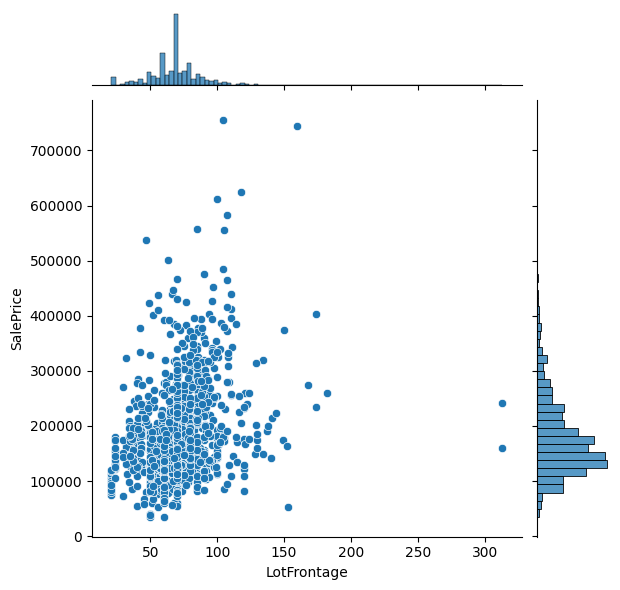

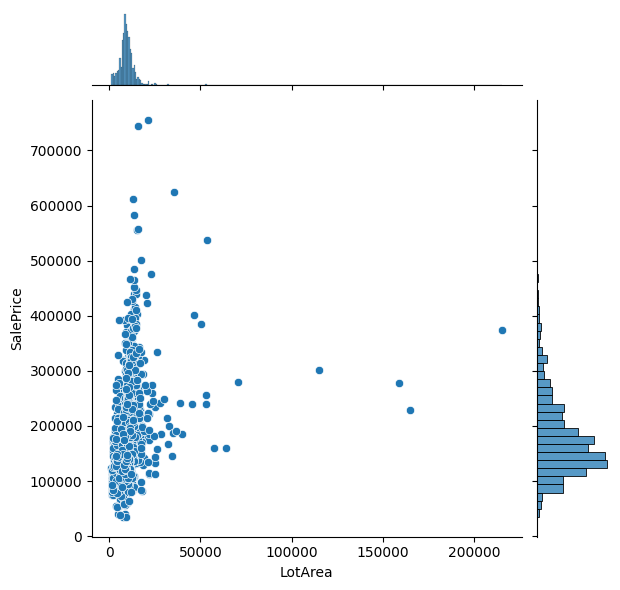

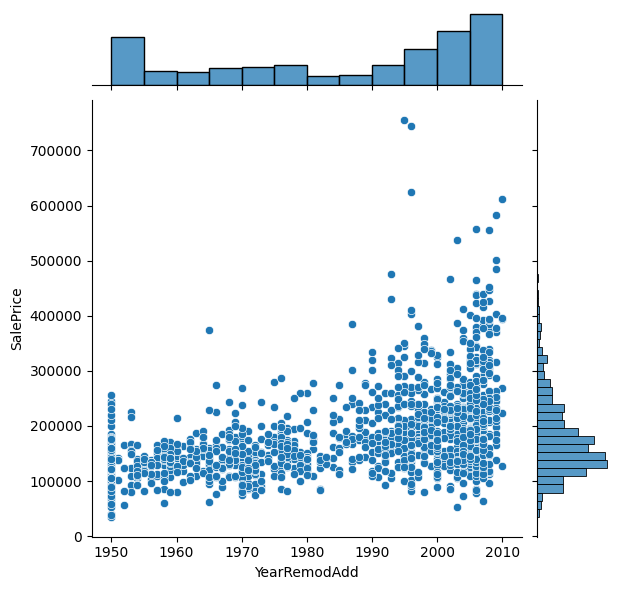

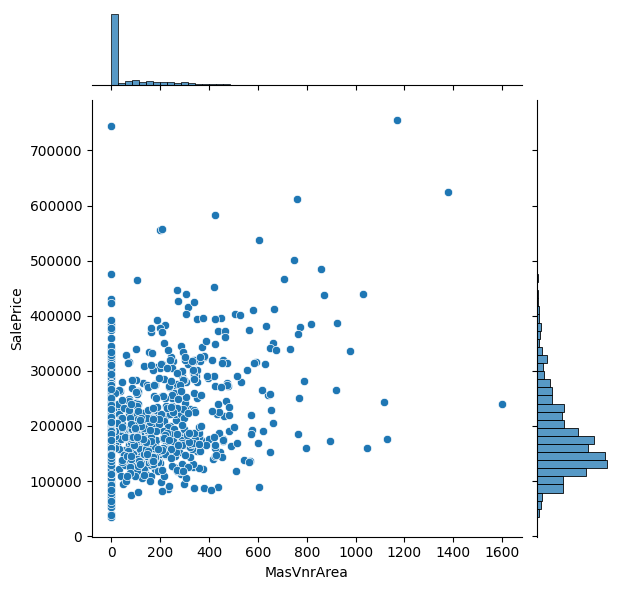

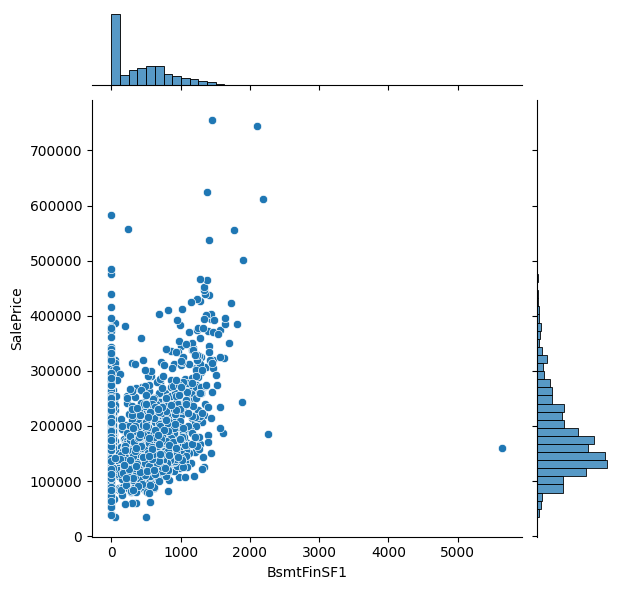

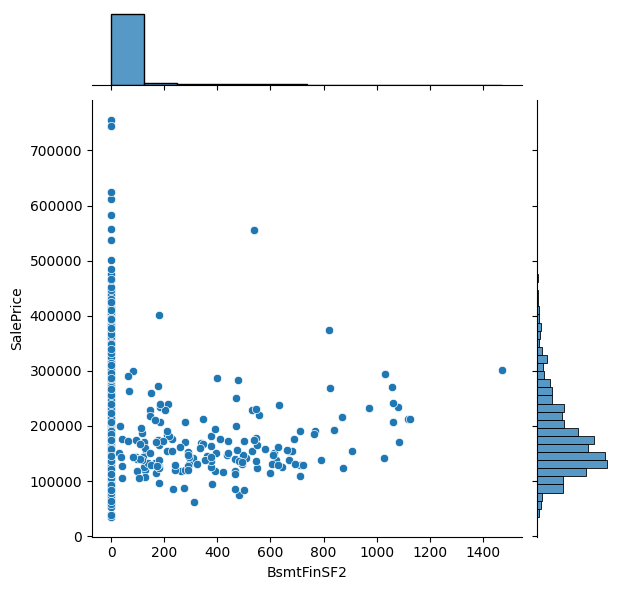

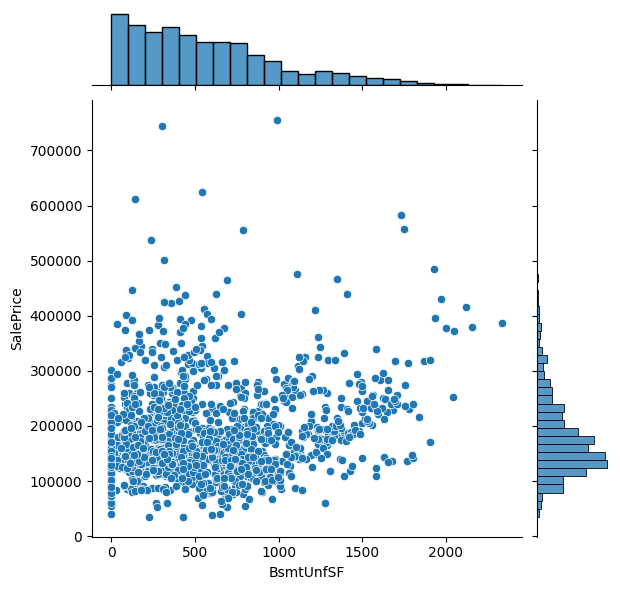

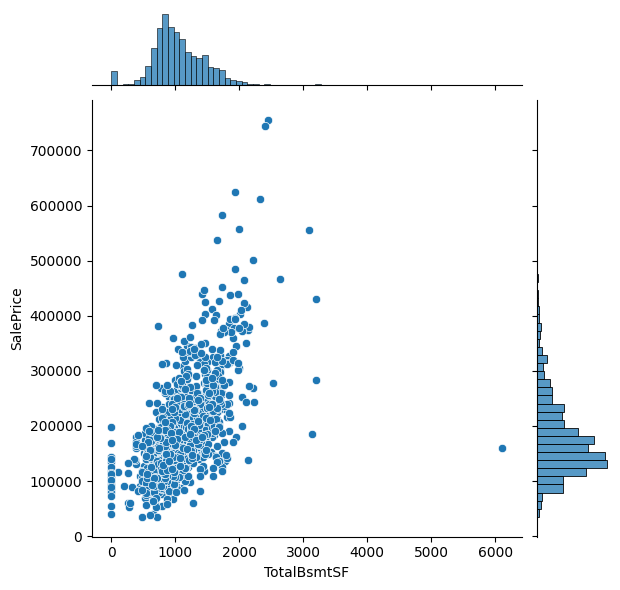

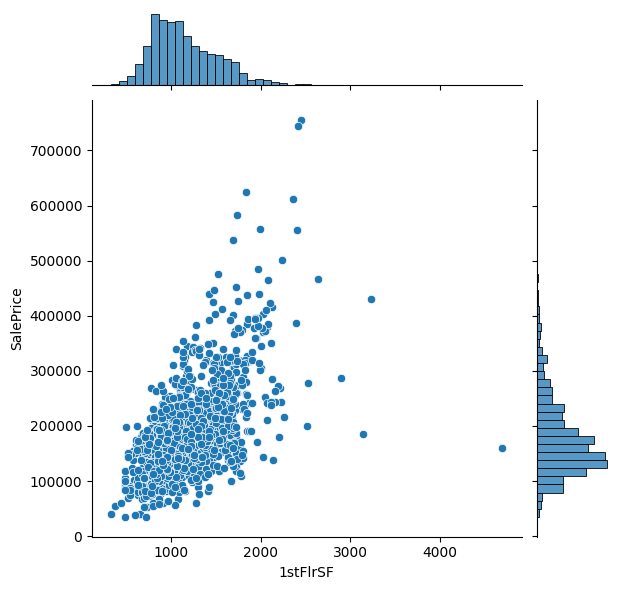

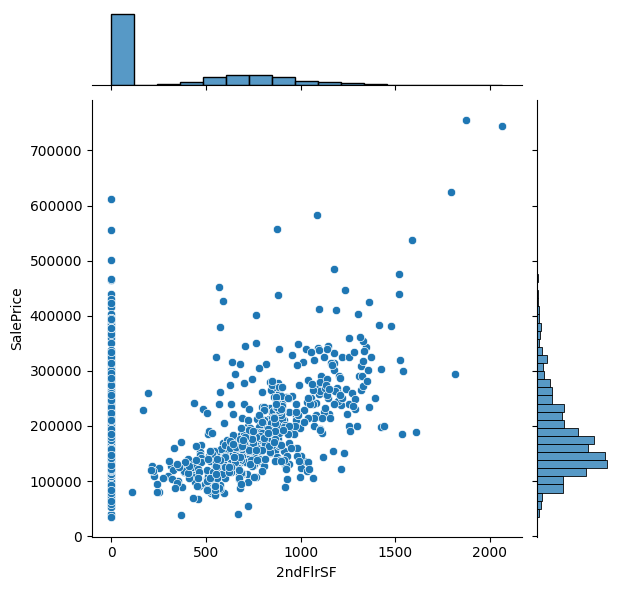

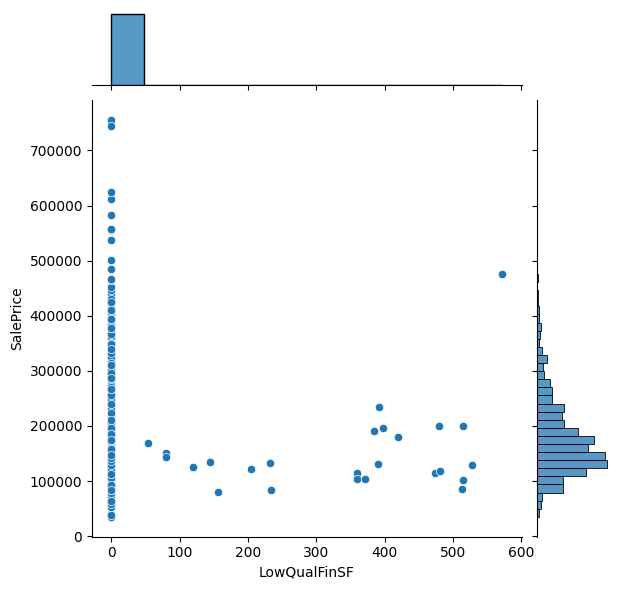

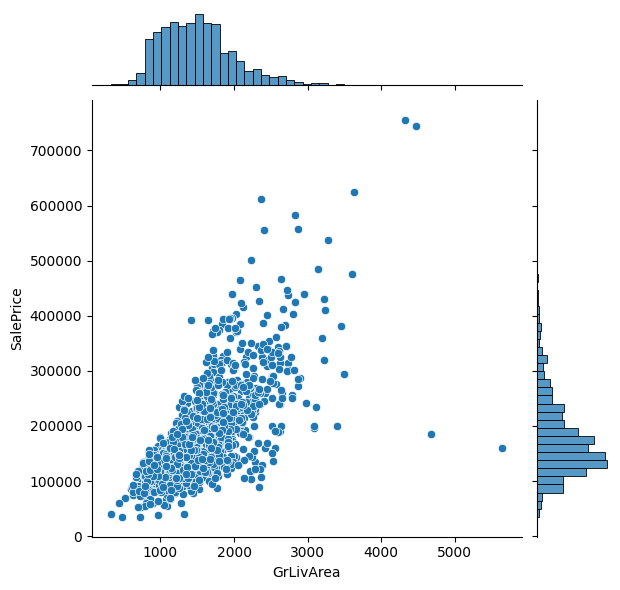

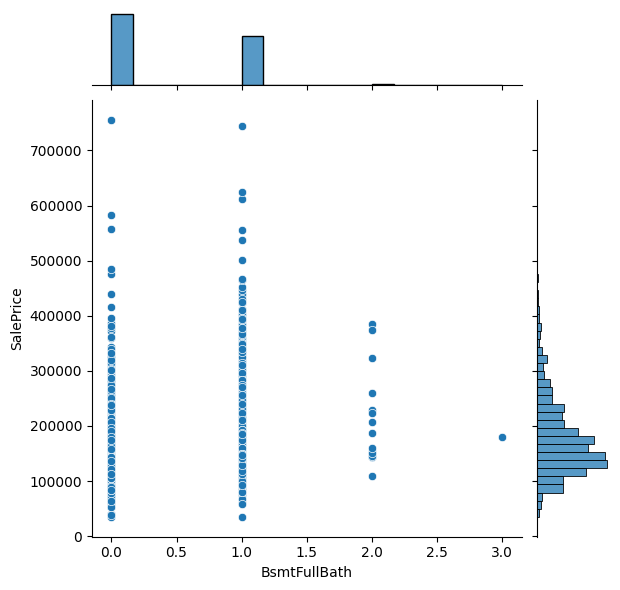

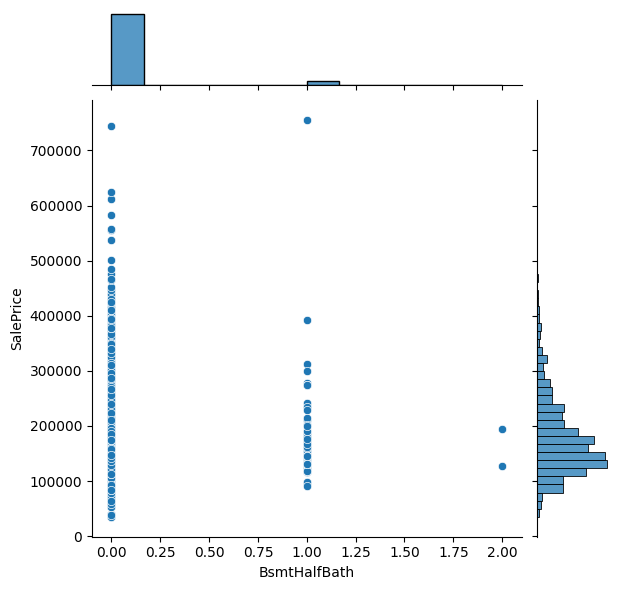

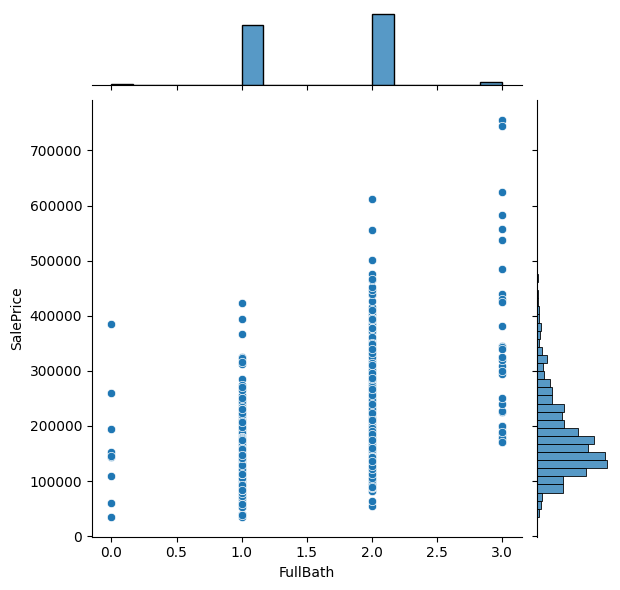

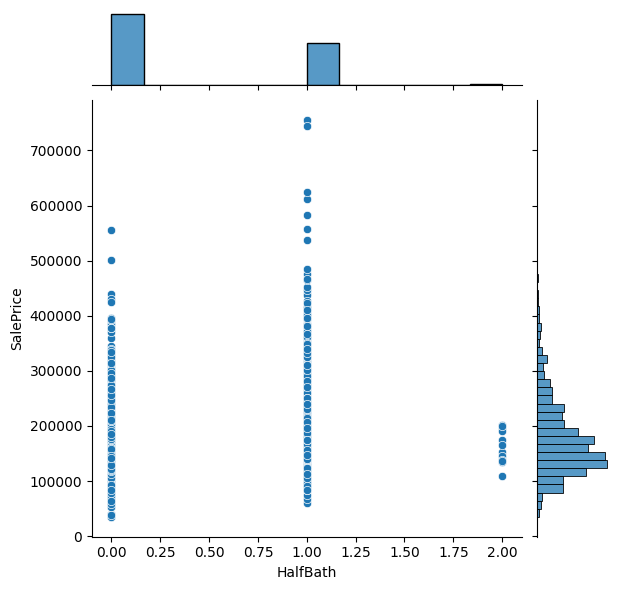

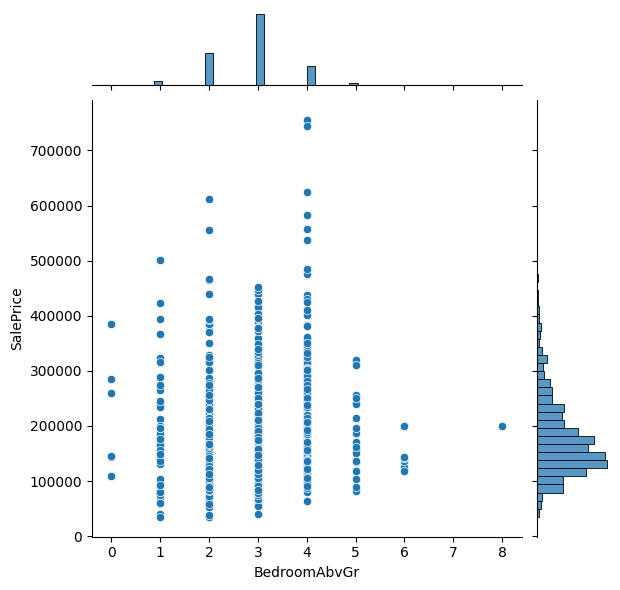

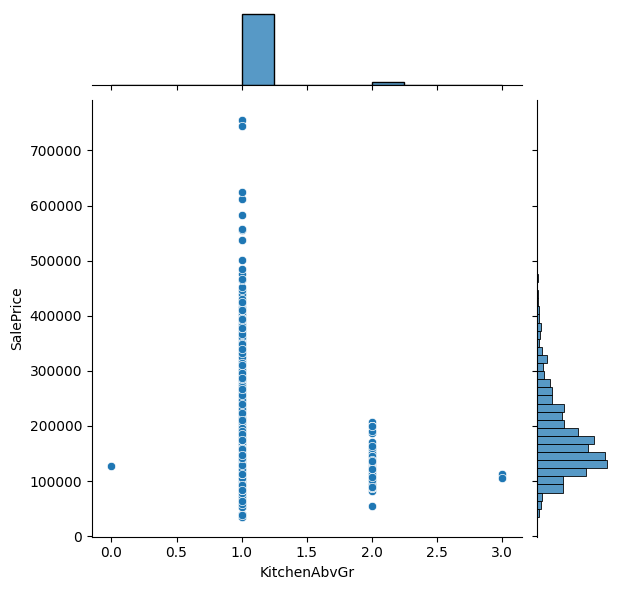

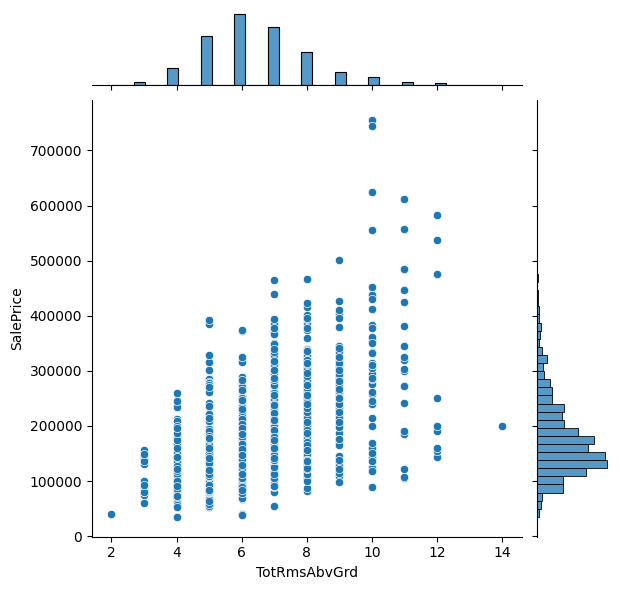

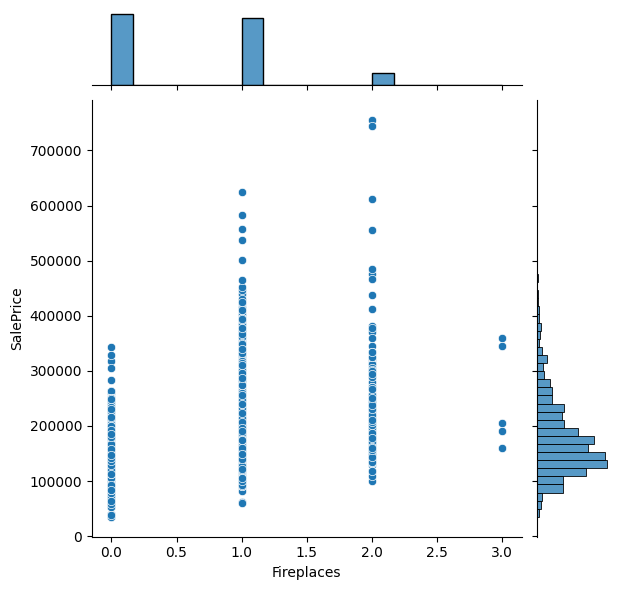

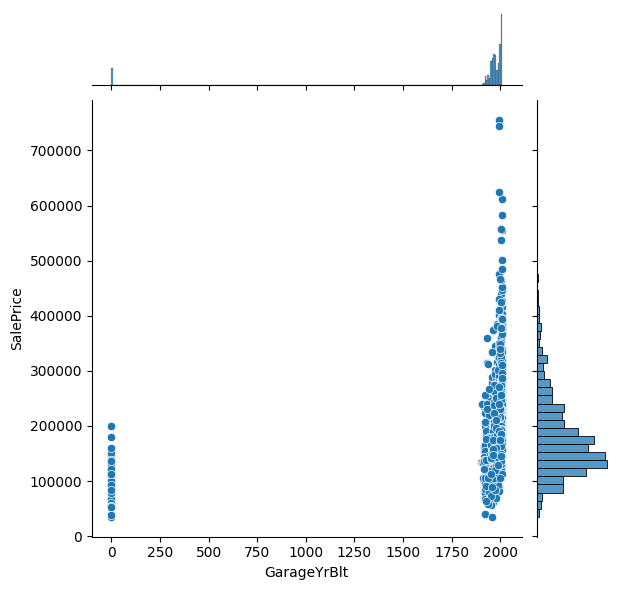

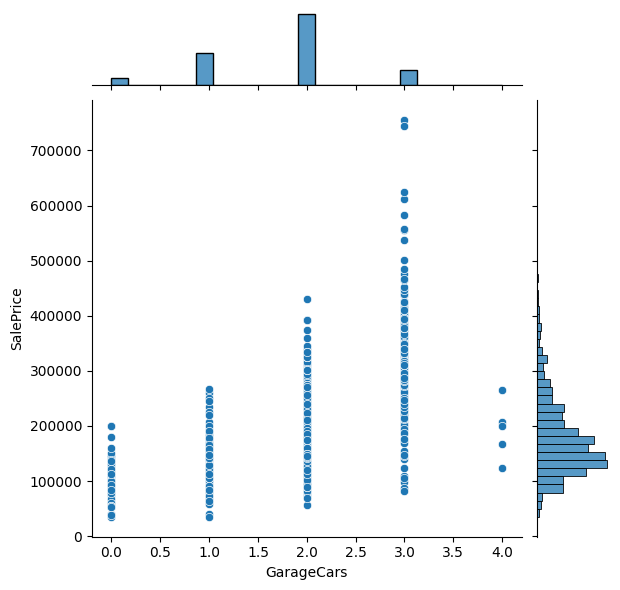

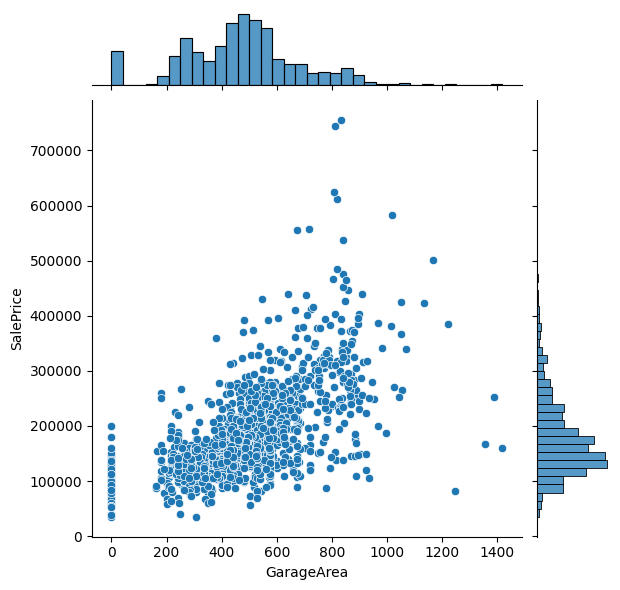

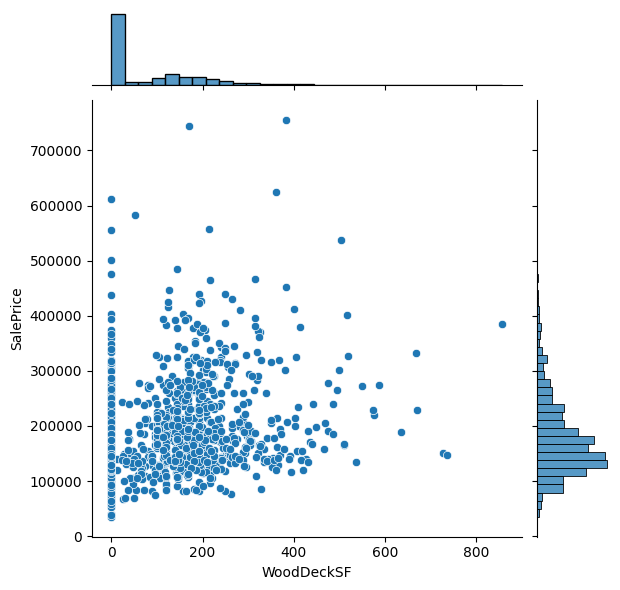

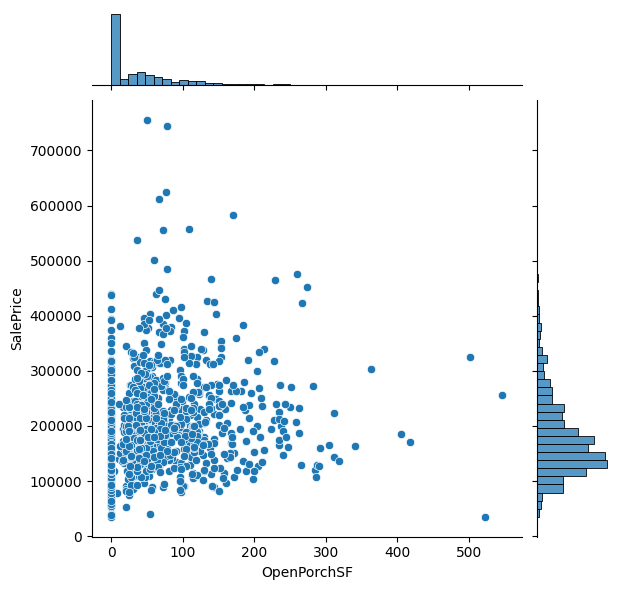

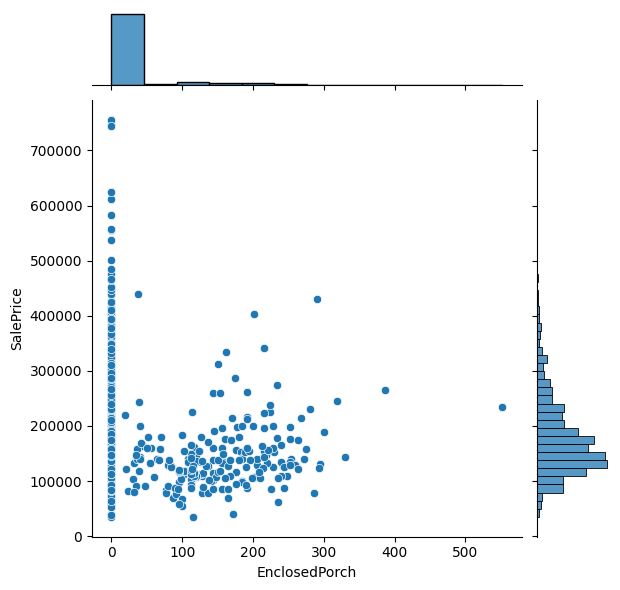

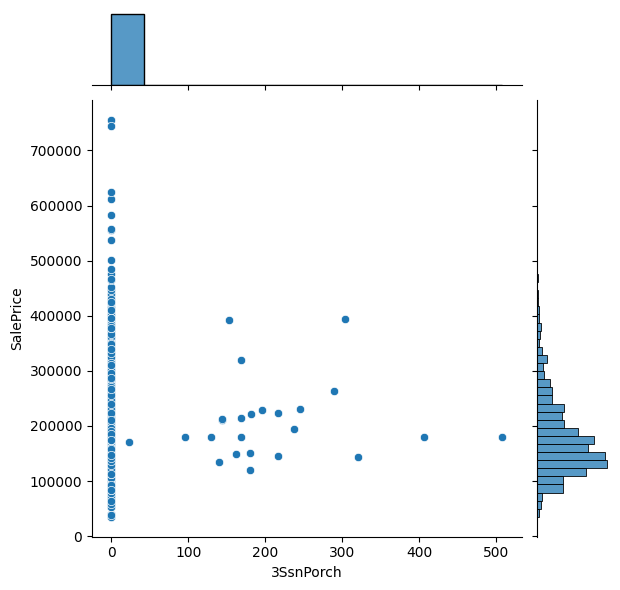

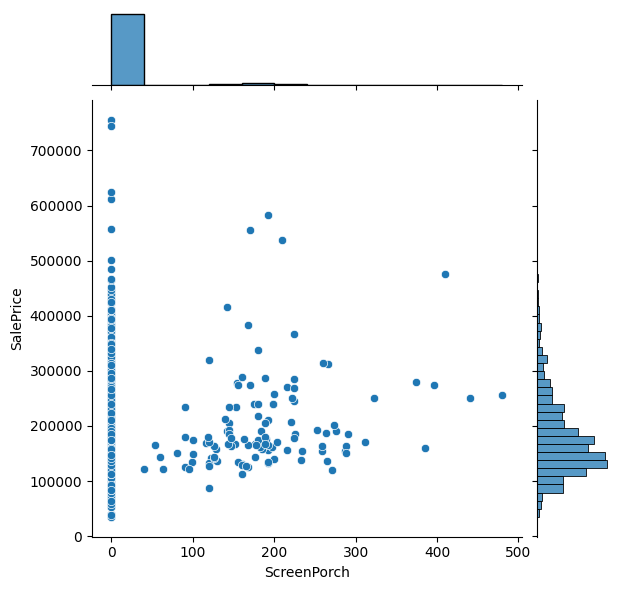

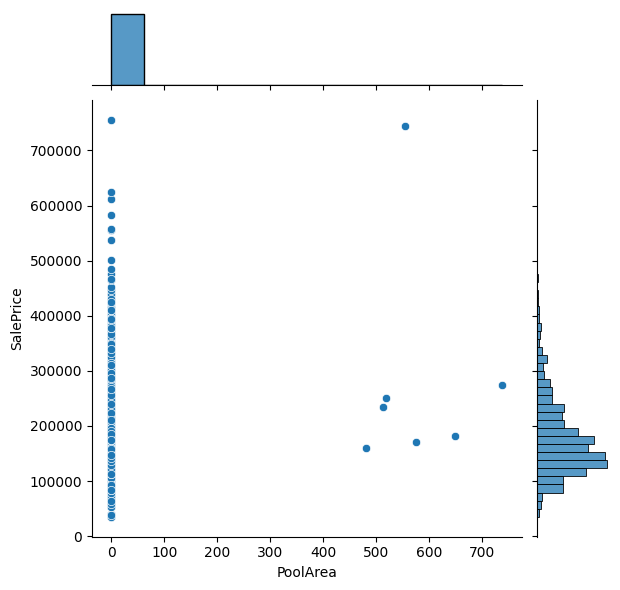

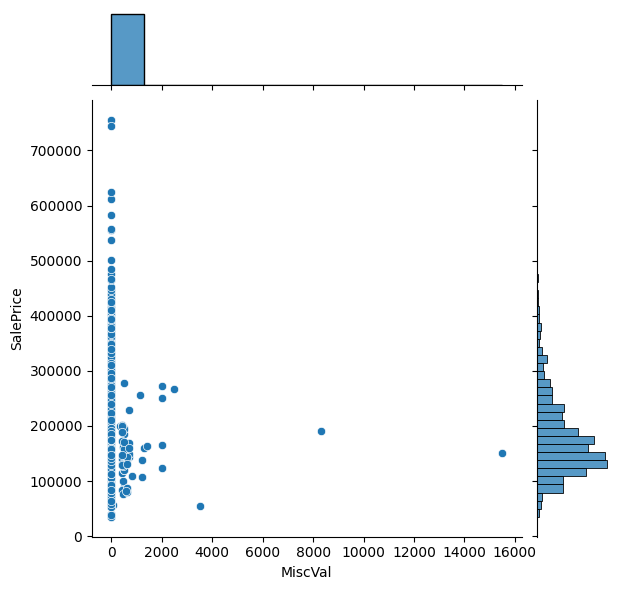

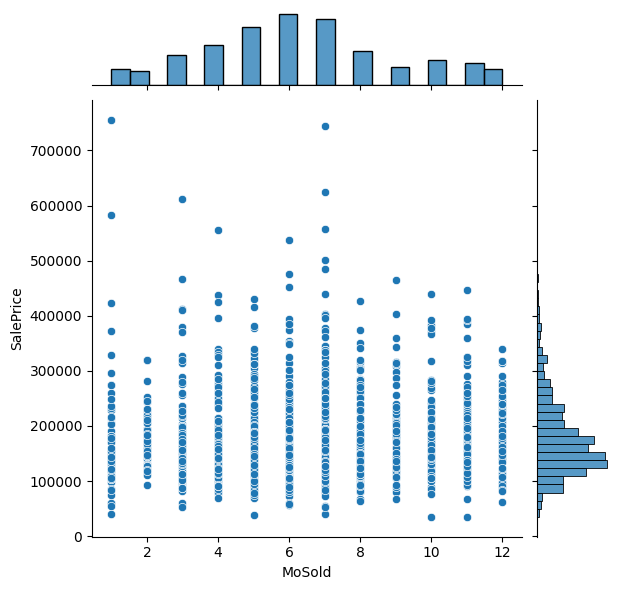

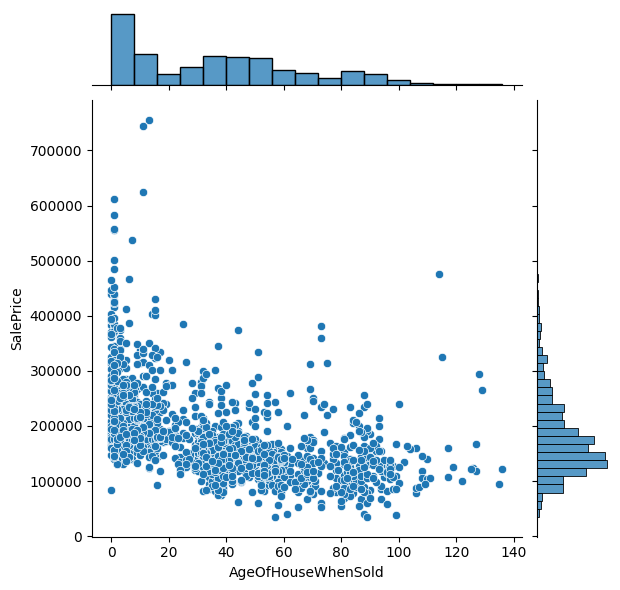

In [776]:
# NUMERICAL COLUMN ANALYSIS
for i, col in enumerate(col_X_numeric):
    print(col)
    AnalyseNumericalColumns(df_house, i, col, col_y)

<Figure size 640x480 with 0 Axes>

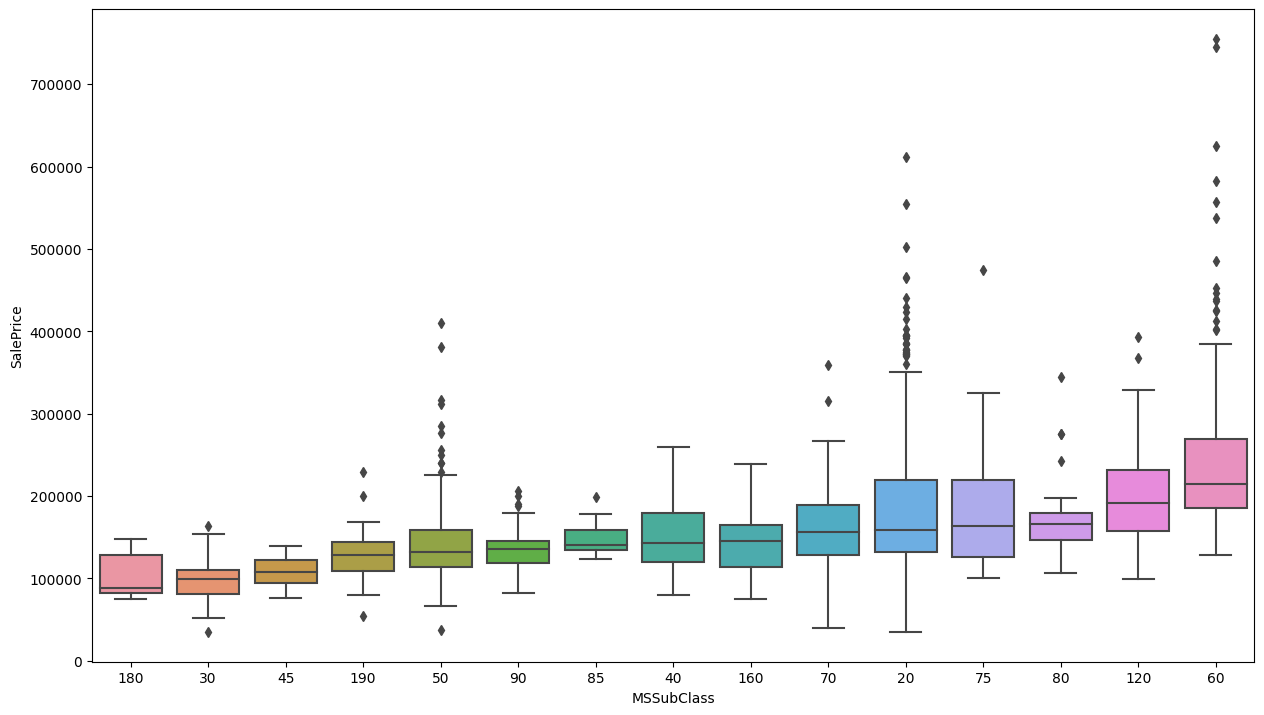

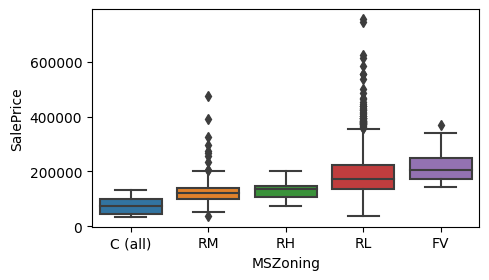

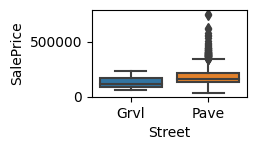

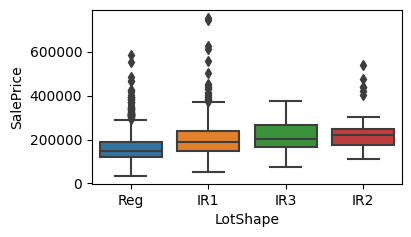

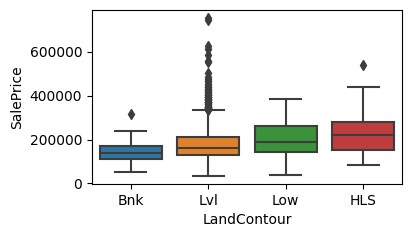

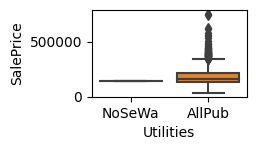

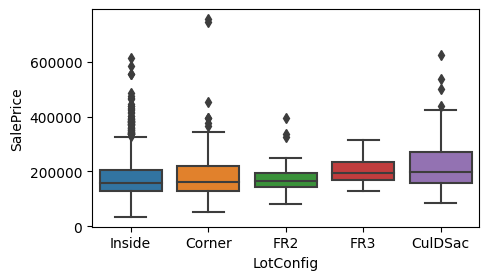

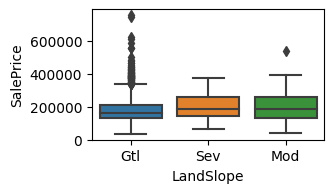

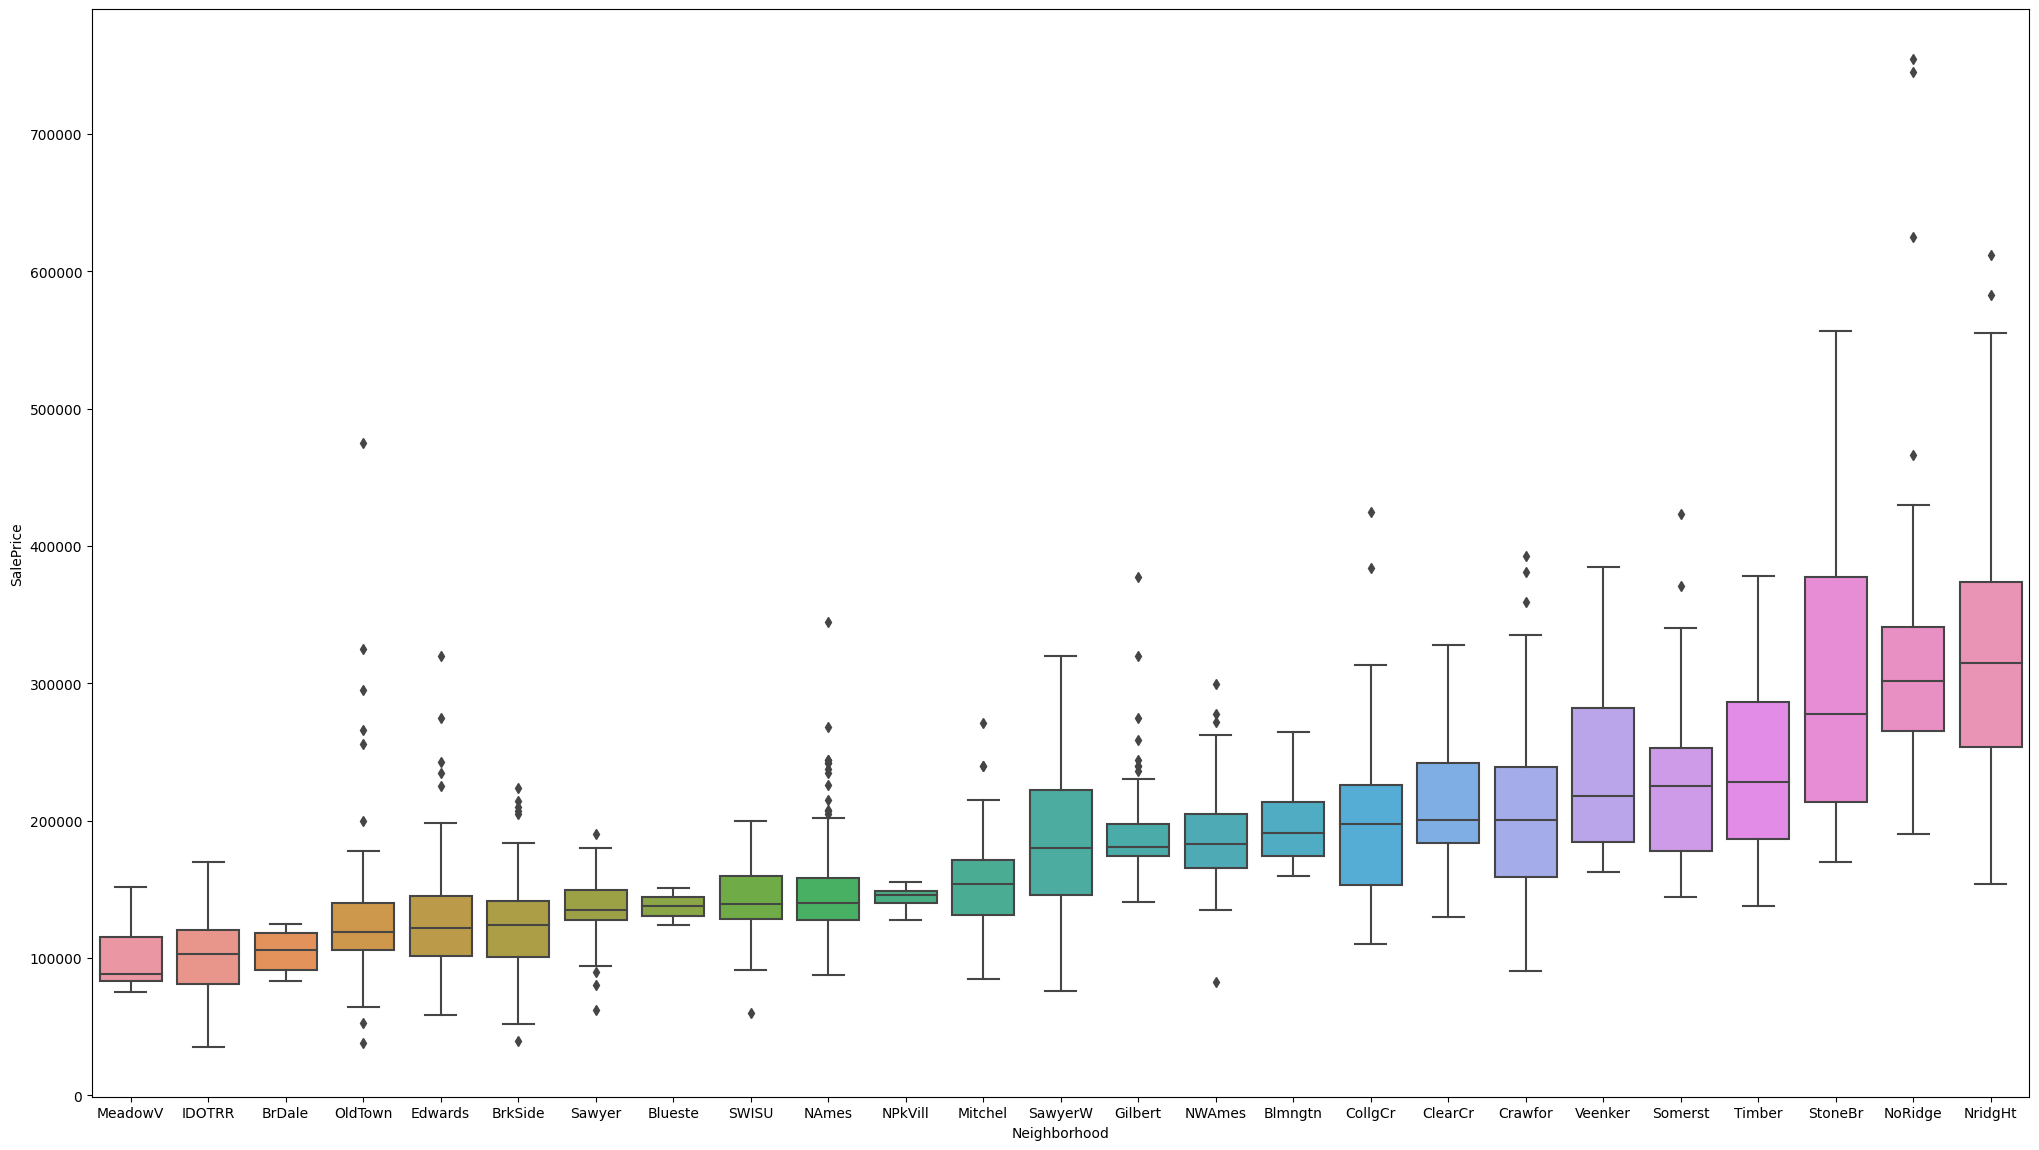

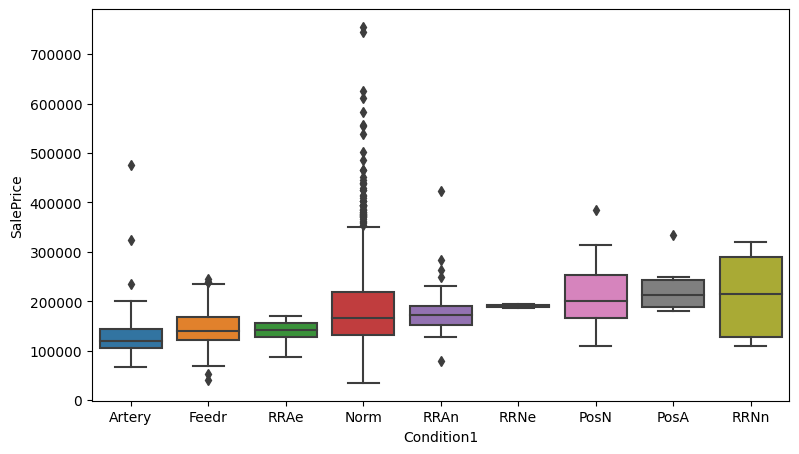

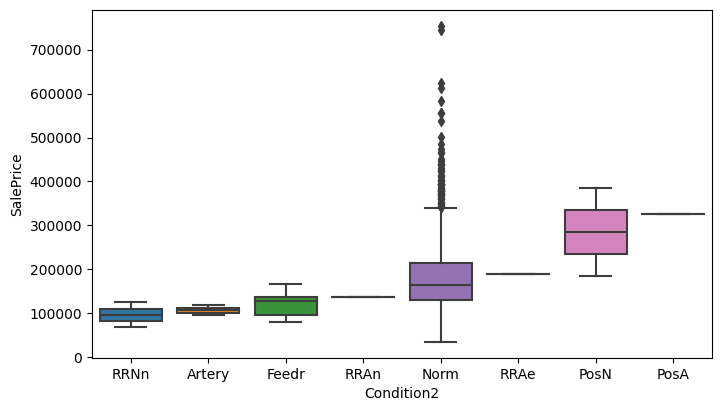

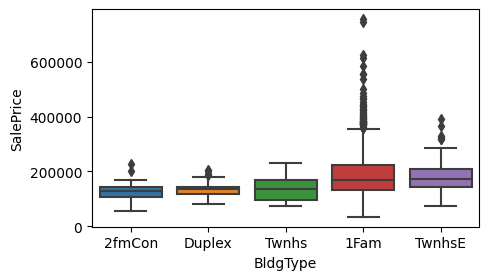

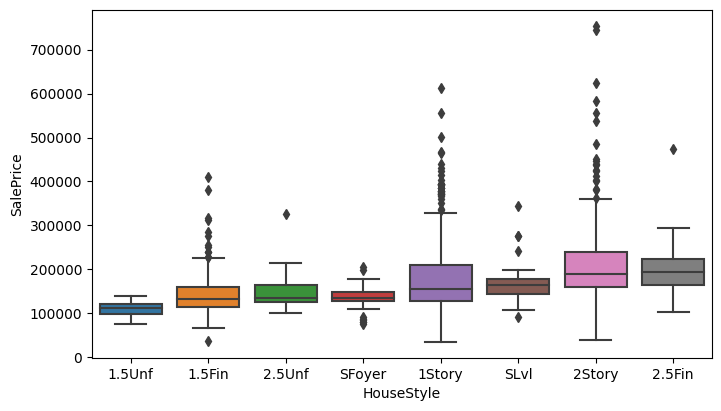

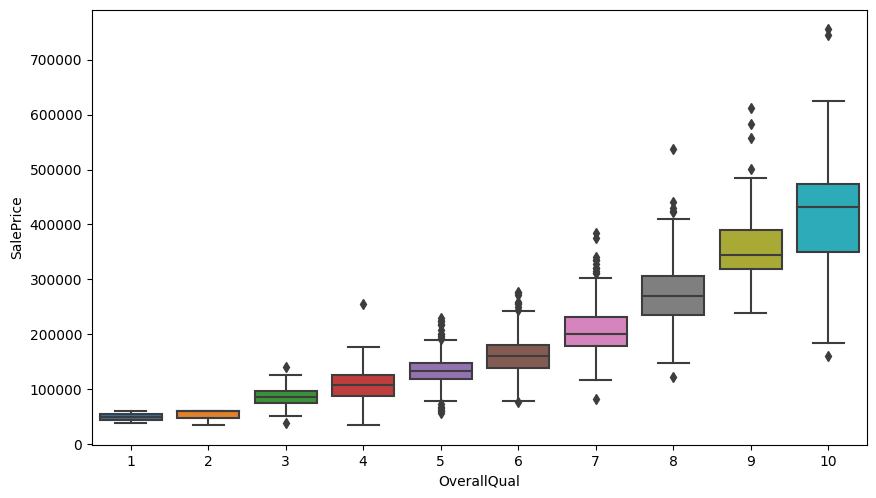

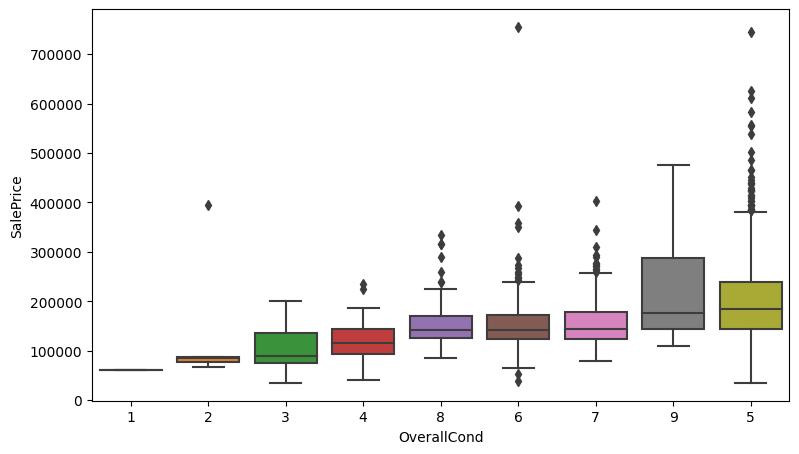

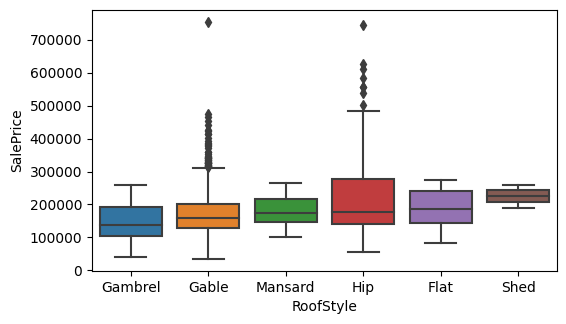

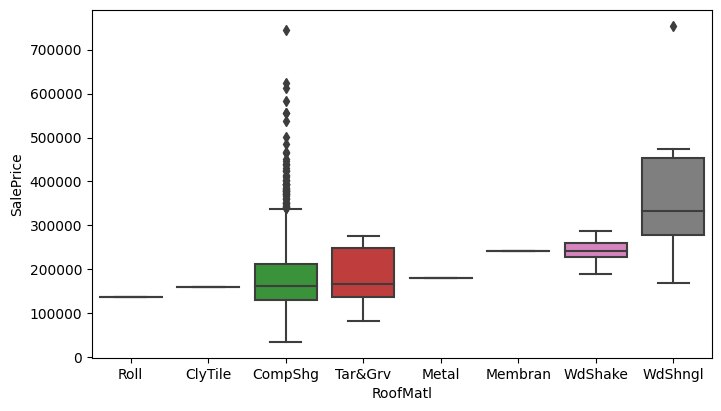

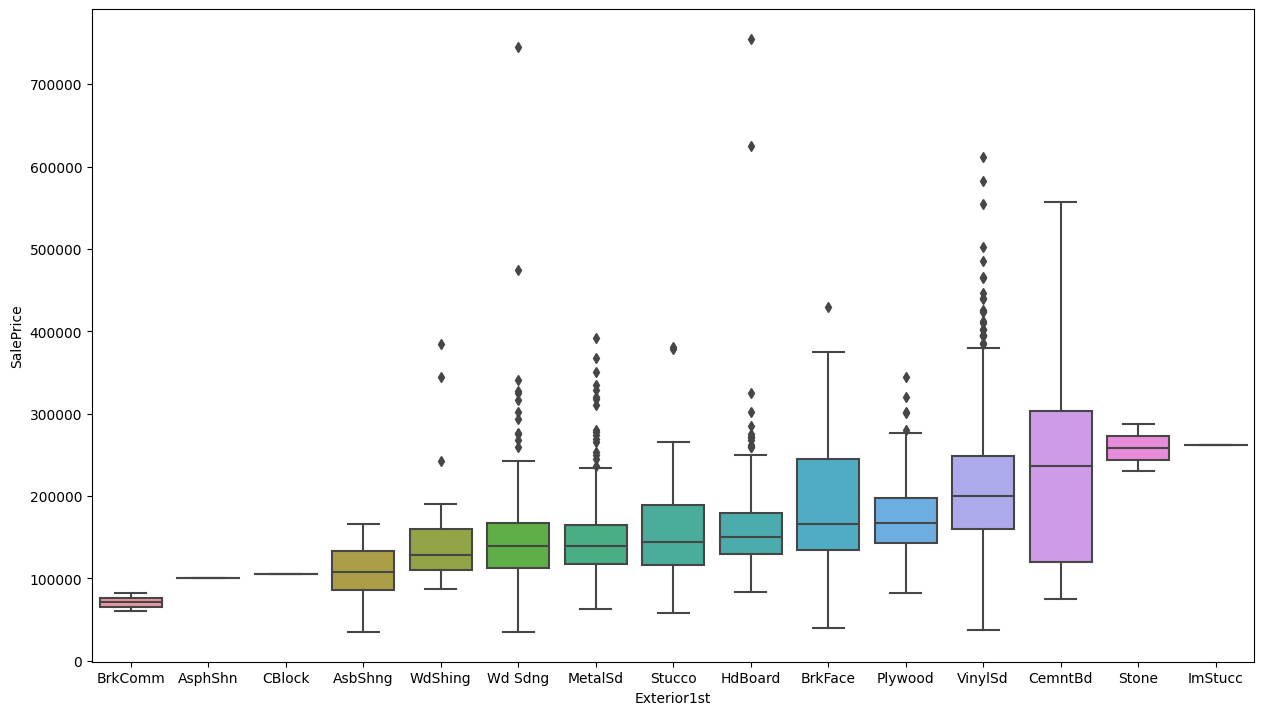

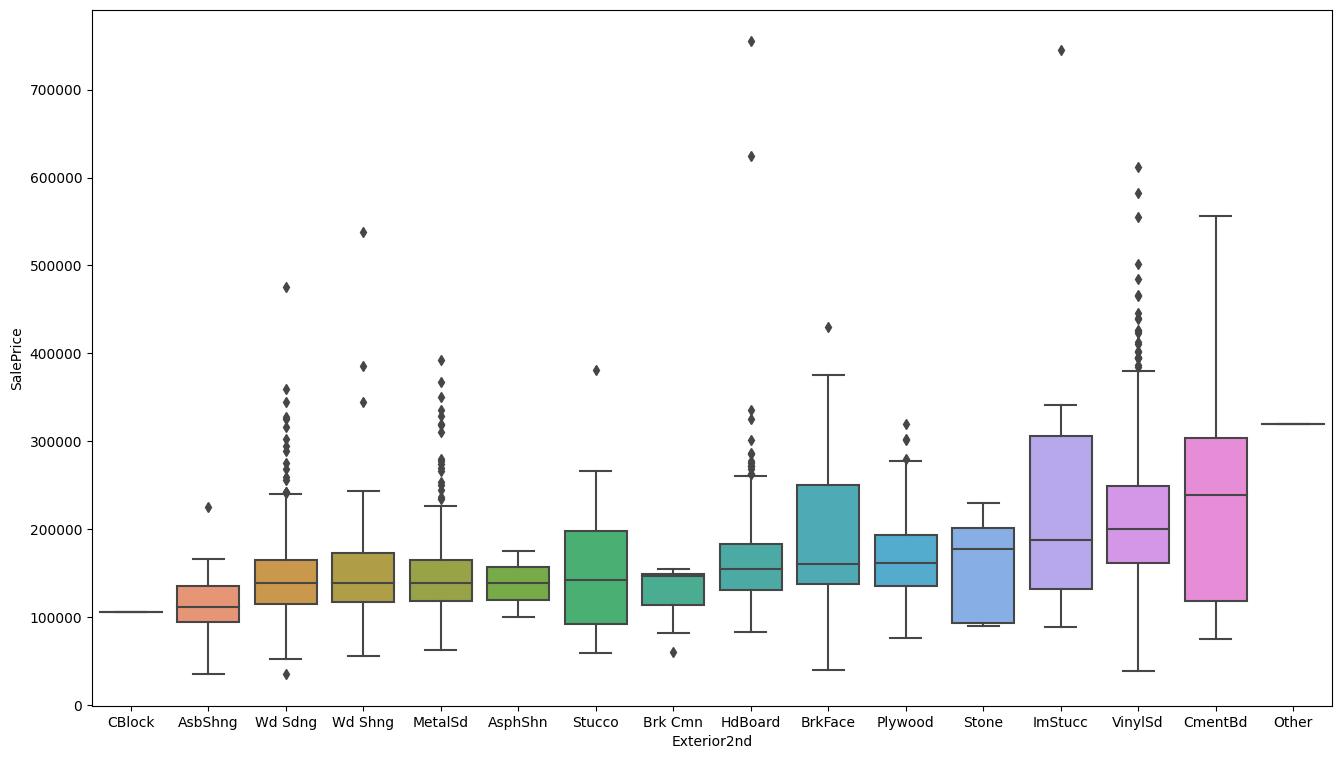

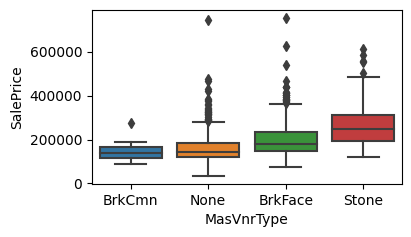

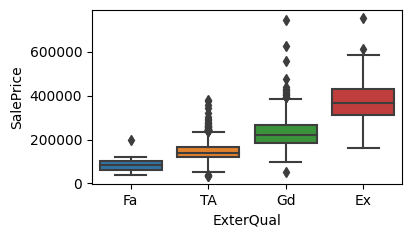

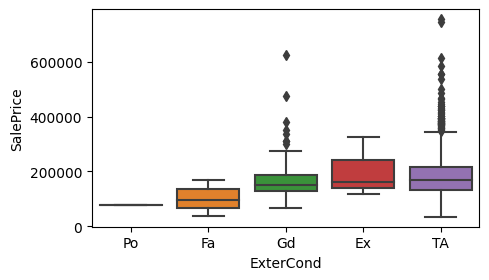

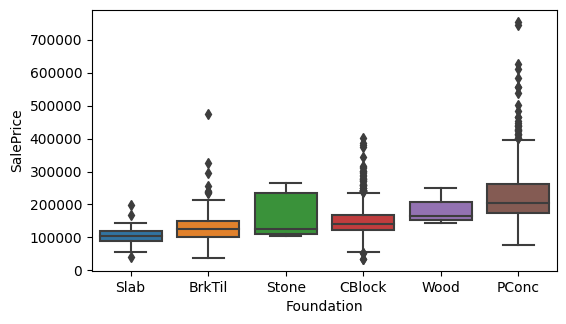

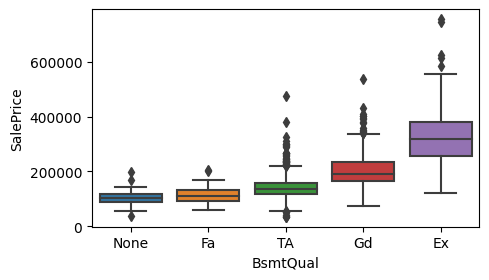

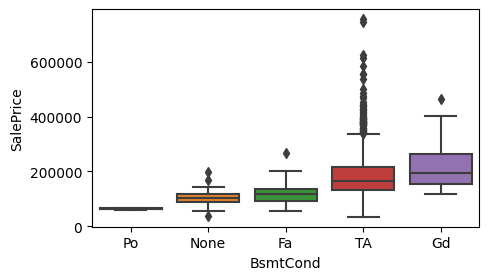

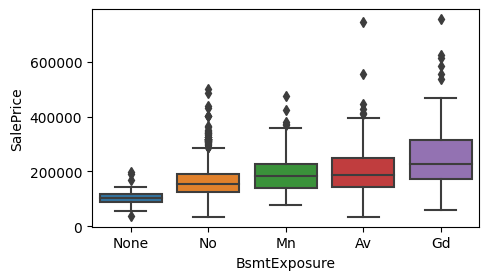

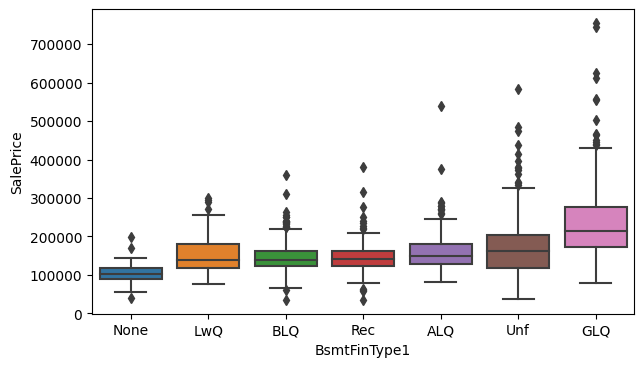

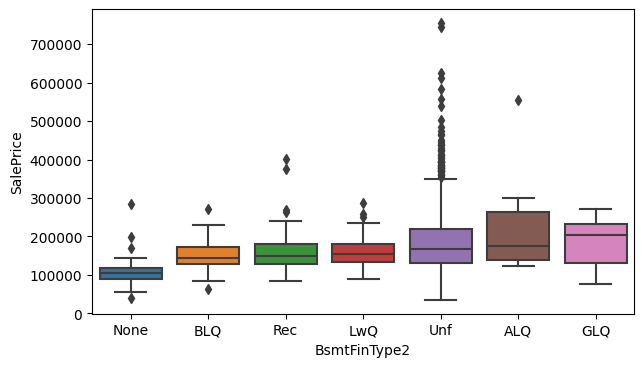

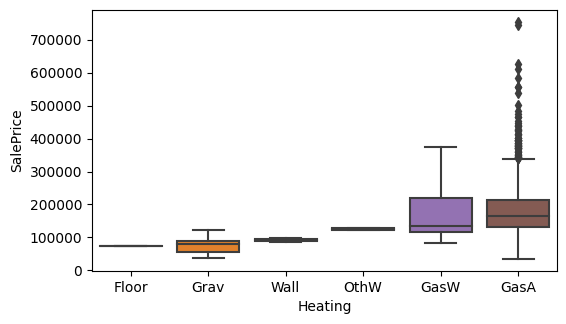

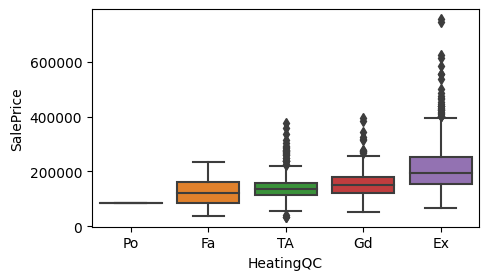

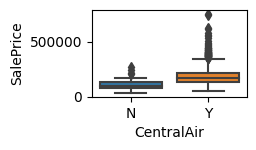

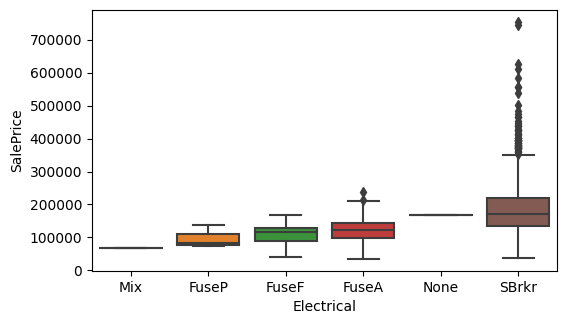

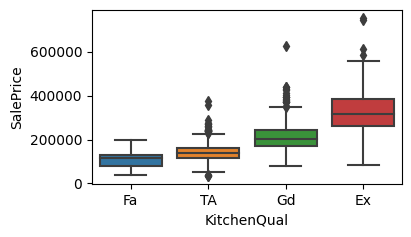

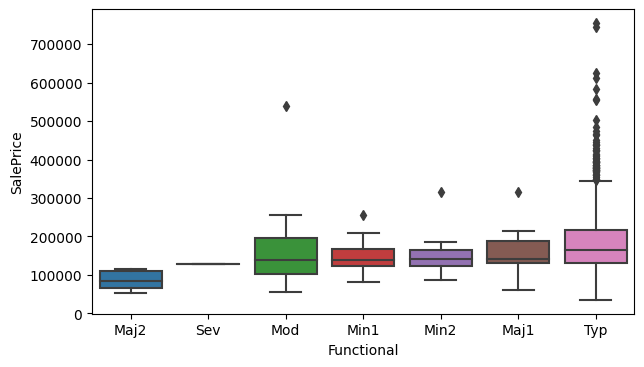

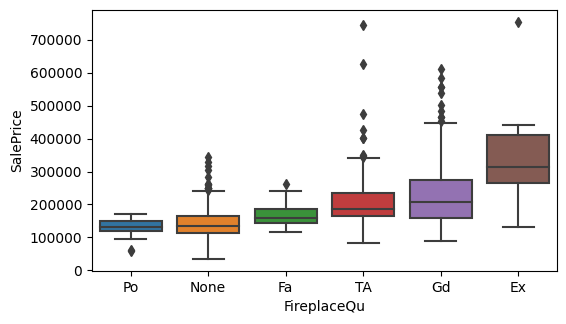

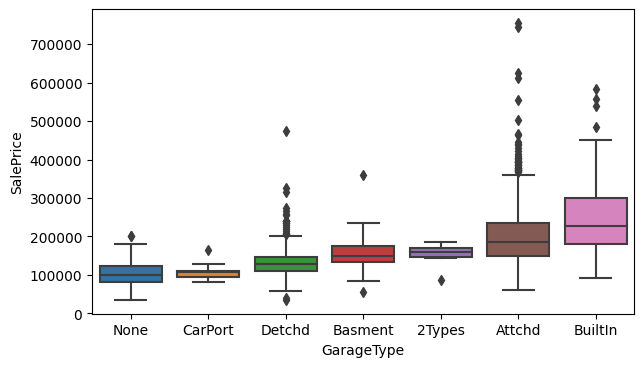

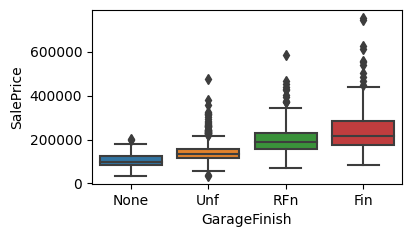

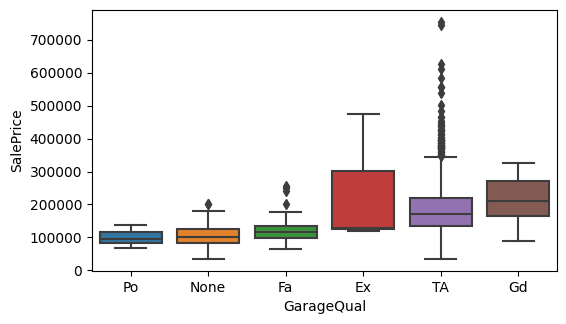

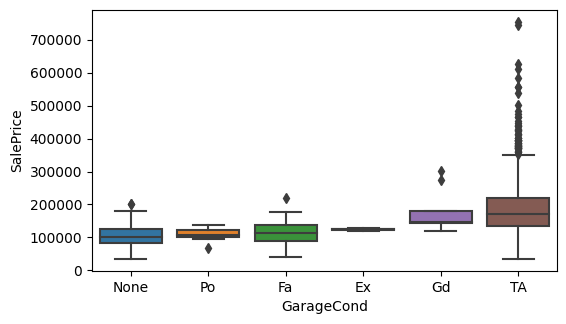

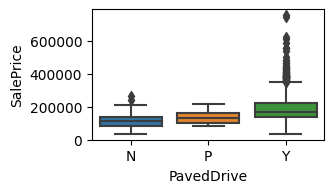

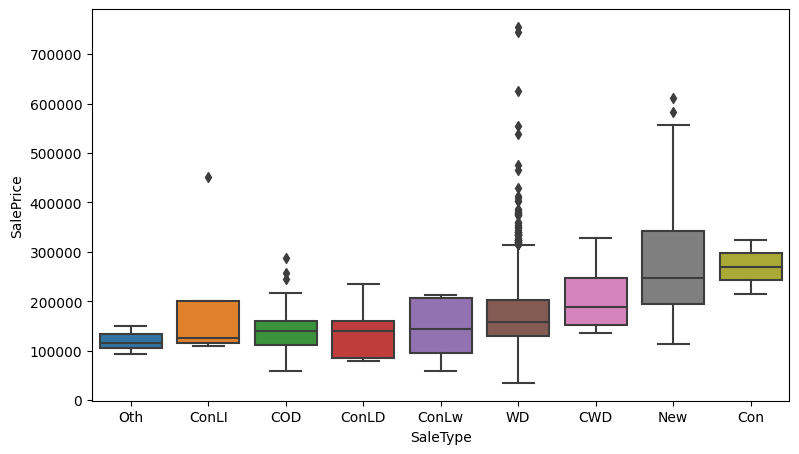

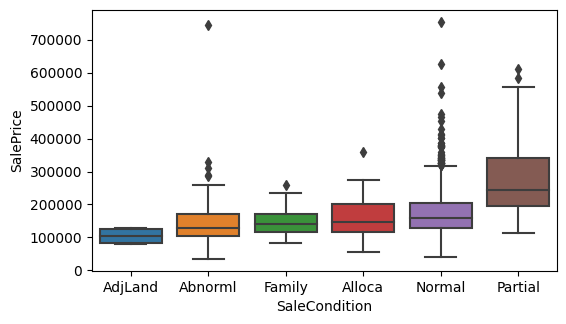

In [777]:
# CATEGORICAL COLUMN ANALYSIS
for i, col in enumerate(col_X_category):
    AnalyseCategoricalColumns(df_house, i, col, col_y)

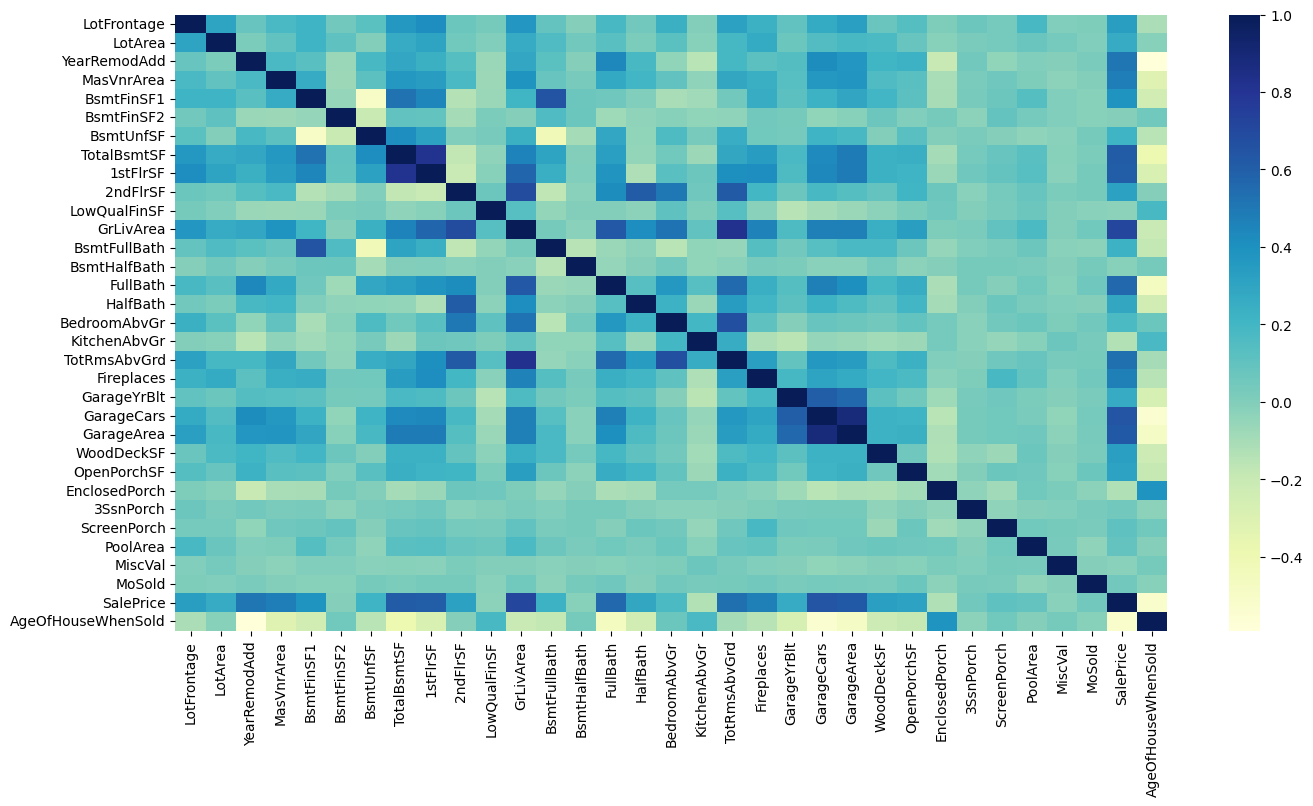

In [778]:
plt.figure(figsize=(16,8))
# heatmap
sns.heatmap(df_house.corr(), cmap="YlGnBu", annot=False)
plt.show()

In [779]:
#df_house.drop(['GarageFinish', 'GarageQual', 'GarageCond','BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF'], axis=1, inplace=True)

# Summary
1. There is linear relationship between independent variable and output variable
2. There is collinearity between independent variables. Notice the darker shades of blue in the heatmap.

# **Data Prep for Modelling**

In [780]:
# Applying the function to the categorical columns
#df_house[['MoSold']] = df_house[['MoSold']].apply(MapMonths)
#df_house['MoSold'] = df_house['MoSold'].astype('category')

In [781]:
df_house.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,AgeOfHouseWhenSold
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,WD,Normal,208500,5
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,WD,Normal,181500,31
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,WD,Normal,223500,7
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,WD,Abnorml,140000,91
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,WD,Normal,250000,8


### Create dummies for categorical fields

In [782]:
# Dumifying all columns of category type using a loop
#for col in col_X_category:
#    # Let's drop the first column from dummy df using 'drop_first = True' otherwise it will get multicollinear
#    dummies = pd.get_dummies(df_house[col], drop_first = True)
#    dummies = dummies.add_prefix(f'{col}_')
#    df_house = pd.concat([df_house, dummies], axis = 1)
#    # Drop original categorical column as we have created the dummies for it
#    df_house.drop([col], axis = 1, inplace = True)

#Create dummy columns for categorical variables and drop the first column
df_house = pd.get_dummies(df_house, drop_first=True)

df_house.info()
df_house.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 275 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(3), int64(30), uint8(242)
memory usage: 721.6 KB


,LotFrontage,LotArea,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,AgeOfHouseWhenSold,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_None,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,Ga

In [783]:
# Preparing Test and Train Set

y = df_house.loc[:, col_y]
X = df_house.loc[:, df_house.columns != col_y]

# scale
scaler = StandardScaler()
scaler.fit(X)

## Splitting X and y into 80% train data and 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


In [784]:
# linear regression with all predictors
lm_simple = LinearRegression()
lm_simple.fit(X_train, y_train)

# predict train
y_train_pred = lm_simple.predict(X_train)
print('Train R2 Score :', metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
# predict test
y_test_pred = lm_simple.predict(X_test)
print('Test R2 Score : ', metrics.r2_score(y_true=y_test, y_pred=y_test_pred))


Train R2 Score : 0.940369656665441
Test R2 Score :  0.6369008154246999


In [785]:
# Simple Linear Regression model parameters
simple_model_parameters = list(lm_simple.coef_)
simple_model_parameters.insert(0, lm_simple.intercept_)
simple_model_parameters = [round(x, 3) for x in simple_model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
sorted(list(zip(simple_model_parameters,cols)), key=lambda x:abs(x[0]), reverse=True)

[(-929558.998, 'constant'),
 (742216.251, 'RoofMatl_Metal'),
 (717205.657, 'RoofMatl_WdShngl'),
 (715135.338, 'RoofMatl_Roll'),
 (710120.606, 'RoofMatl_CompShg'),
 (702878.554, 'RoofMatl_WdShake'),
 (702285.998, 'RoofMatl_Tar&Grv'),
 (-257476.595, 'Condition2_PosN'),
 (109556.536, 'OverallQual_10'),
 (-89344.004, 'GarageQual_Po'),
 (-88570.198, 'Condition2_RRAe'),
 (-80736.16, 'GarageQual_Fa'),
 (-77030.293, 'GarageQual_Gd'),
 (-76892.467, 'GarageQual_TA'),
 (67531.06, 'GarageCond_TA'),
 (67399.484, 'GarageCond_Fa'),
 (66599.881, 'GarageCond_Po'),
 (-65680.414, 'Functional_Sev'),
 (64584.716, 'GarageCond_Gd'),
 (62119.019, 'RoofStyle_Shed'),
 (57340.726, 'OverallQual_9'),
 (-50810.009, 'Exterior1st_ImStucc'),
 (-40937.698, 'LandSlope_Sev'),
 (39859.626, 'MSZoning_FV'),
 (39771.497, 'Exterior2nd_ImStucc'),
 (37904.023, 'GarageType_CarPort'),
 (-37859.625, 'Utilities_NoSeWa'),
 (-35340.644, 'Foundation_Wood'),
 (31957.675, 'MSZoning_RM'),
 (-31150.586, 'Neighborhood_MeadowV'),
 (30901.88

Summary:

Simple Linear Regression gave us a complex model with most of the coefficients as non-zero values.
Simple Linear Regression has not helped us in the feature selection.

#RFE

In [786]:

# Running RFE with the output number of the variable equal to 20
lm_rfe = LinearRegression()
lm_rfe.fit(X_train, y_train)

rfe = RFE(lm_rfe, n_features_to_select = 30)
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('LotFrontage', False, 226),
 ('LotArea', False, 242),
 ('YearRemodAdd', False, 218),
 ('MasVnrArea', False, 235),
 ('BsmtFinSF1', False, 230),
 ('BsmtFinSF2', False, 232),
 ('BsmtUnfSF', False, 234),
 ('TotalBsmtSF', False, 227),
 ('1stFlrSF', False, 231),
 ('2ndFlrSF', False, 228),
 ('LowQualFinSF', False, 229),
 ('GrLivArea', False, 221),
 ('BsmtFullBath', False, 34),
 ('BsmtHalfBath', False, 157),
 ('FullBath', False, 19),
 ('HalfBath', False, 32),
 ('BedroomAbvGr', False, 199),
 ('KitchenAbvGr', False, 82),
 ('TotRmsAbvGrd', False, 95),
 ('Fireplaces', False, 50),
 ('GarageYrBlt', False, 238),
 ('GarageCars', False, 45),
 ('GarageArea', False, 225),
 ('WoodDeckSF', False, 239),
 ('OpenPorchSF', False, 241),
 ('EnclosedPorch', False, 240),
 ('3SsnPorch', False, 223),
 ('ScreenPorch', False, 236),
 ('PoolArea', False, 222),
 ('MiscVal', False, 243),
 ('MoSold', False, 210),
 ('AgeOfHouseWhenSold', False, 214),
 ('MSSubClass_30', False, 46),
 ('MSSubClass_40', False, 64),
 ('MSSubCl

In [787]:
ls_selected_col = X_train.columns[rfe.support_]
ls_selected_col

Index(['MSSubClass_90', 'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_180', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'OverallCond_2', 'OverallCond_3', 'OverallCond_4', 'OverallCond_5', 'OverallCond_6', 'OverallCond_7', 'OverallCond_8', 'OverallCond_9', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_CBlock', 'Exterior2nd_CBlock', 'BsmtQual_None', 'BsmtCond_None', 'BsmtCond_Po', 'BsmtExposure_None', 'BsmtFinType1_None', 'BsmtFinType2_None', 'GarageType_None', 'GarageFinish_None', 'GarageQual_None', 'GarageCond_None'], dtype='object')

In [788]:
lm_rfe = CreateLRModel(X_train, y_train,  ls_selected_col)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     16.72
Date:                Sat, 15 Apr 2023   Prob (F-statistic):           7.39e-49
Time:                        15:26:23   Log-Likelihood:                -14660.
No. Observations:                1168   AIC:                         2.936e+04
Df Residuals:                    1148   BIC:                         2.946e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 1.5e+05   8428

**Summary:**

R2 Score of this model is only 62%. The features selected have multicollinearity and hence needs refinement to choose appropriate features for the model.

In [789]:
def BuildRidgeOrLassoModel(X_train, y_train, X_test, params, model='ridge'):

  if model == 'ridge':
    model_estimator = Ridge()
  else:
    model_estimator = Lasso()

  model_gscv = GridSearchCV(estimator = model_estimator, 
                          param_grid = params, 
                          scoring= 'neg_mean_absolute_error', 
                          cv = 5, 
                          return_train_score=True,
                          verbose = 1)        
      
  model_gscv.fit(X_train, y_train)
  alpha = model_gscv.best_params_["alpha"]
  print("Optimum alpha for %s is %f" %(model, alpha))
  final_model = model_gscv.best_estimator_

  final_model.fit(X_train, y_train)
  y_train_pred = final_model.predict(X_train)
  y_test_pred = final_model.predict(X_test)
 
  # Model Evaluation
  print(model," Regression with ",alpha)
  print("===================================")
  print('R2 score (train) : ',r2_score(y_train,y_train_pred))
  print('R2 score (test) : ',r2_score(y_test,y_test_pred))
  print('RMSE (train) : ', np.sqrt(mean_squared_error(y_train, y_train_pred)))
  print('RMSE (test) : ', np.sqrt(mean_squared_error(y_test, y_test_pred)))

  return final_model, y_train_pred, y_test_pred, alpha

# Ridge Regression

In [790]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge_final_model, ridge_y_train, ridge_y_predicted, ridge_alpha = BuildRidgeOrLassoModel(X_train, y_train, X_test, params, model='ridge')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Optimum alpha for ridge is 10.000000
ridge  Regression with  10.0
R2 score (train) :  0.8961186794997911
R2 score (test) :  0.8783476792683764
RMSE (train) :  24891.87356629834
RMSE (test) :  30546.898105583587


# Lasso Regression

In [791]:
params = {'alpha': [0.000001, 0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 10000]}

lasso_final_model, lasso_y_train, lasso_y_predicted, lasso_alpha = BuildRidgeOrLassoModel(X_train, y_train, X_test, params, model='lasso')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Optimum alpha for lasso is 100.000000
lasso  Regression with  100
R2 score (train) :  0.8971837255577236
R2 score (test) :  0.8848652861991175
RMSE (train) :  24763.94251267894
RMSE (test) :  29717.348680928757


# Ridge vs Lasso Regression

In [792]:
model_coefficients = pd.DataFrame(index=X_test.columns)
model_coefficients.rows = X_test.columns

model_coefficients['Ridge (alpha= ', ridge_alpha , ')'] = ridge_final_model.coef_
model_coefficients['Lasso (alpha= ', lasso_alpha ,')'] = lasso_final_model.coef_
pd.set_option('display.max_rows', None)
model_coefficients

,"(Ridge (alpha= , 10.0, ))","(Lasso (alpha= , 100, ))"
LotFrontage,-155.324258,-176.117027
LotArea,0.390066,0.400834
YearRemodAdd,139.742575,169.038182
MasVnrArea,14.603426,10.190300
BsmtFinSF1,-1.182434,2.266602
BsmtFinSF2,7.020505,9.948131
BsmtUnfSF,-0.923075,2.111508
TotalBsmtSF,4.914996,1.603155
1stFlrSF,5.154998,32.587878
2ndFlrSF,25.091408,51.658675


Text(0.5, 0, 'Errors')

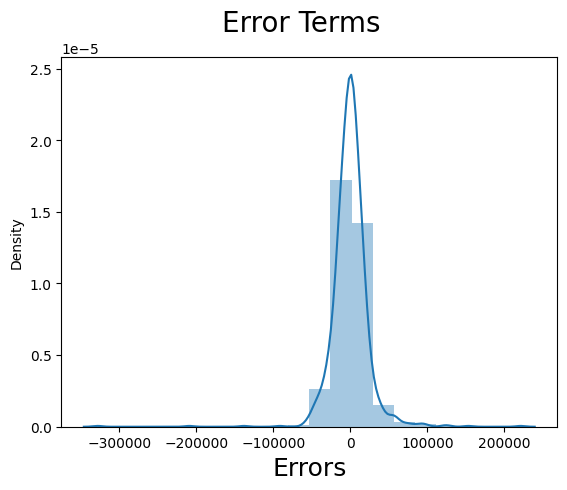

In [793]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - lasso_y_train ), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

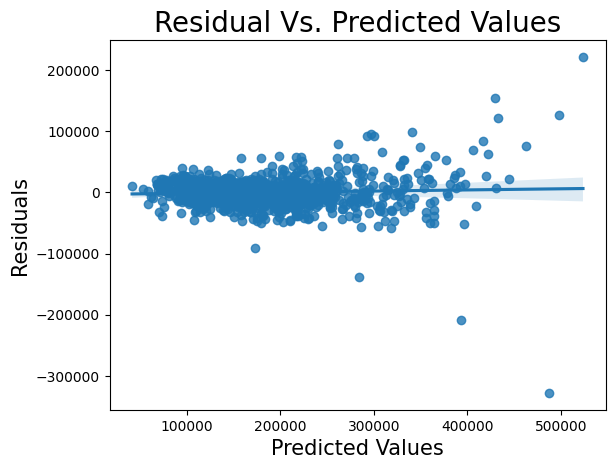

In [794]:
# Plot residuals against the predicted values
sns.regplot(x=lasso_y_train , y=(y_train - lasso_y_train ))
plt.title('Residual Vs. Predicted Values', fontdict={'fontsize': 20})
plt.xlabel('Predicted Values', fontdict={'fontsize': 15})
plt.ylabel('Residuals', fontdict={'fontsize': 15})
plt.show()

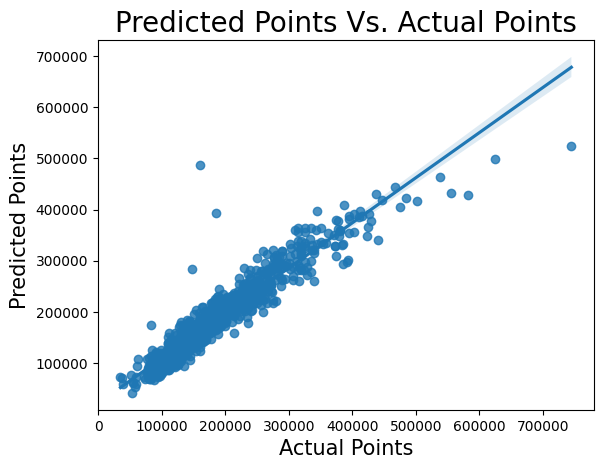

In [795]:
# Plot the predicted value against Actual data
sns.regplot(x=y_train, y=lasso_y_train )
plt.title('Predicted Points Vs. Actual Points', fontdict={'fontsize': 20})
plt.xlabel('Actual Points', fontdict={'fontsize': 15})
plt.ylabel('Predicted Points', fontdict={'fontsize': 15})
plt.show()

In [796]:
# lasso model parameters
model_parameters = list(lasso_final_model.coef_)
model_parameters.insert(0, lasso_final_model.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
lasso_selected_features = []
for k,v in sorted(list(zip(model_parameters,cols)), key=lambda x:abs(x[0]), reverse=True)[1:31]:
    lasso_selected_features.append(v)
sorted(list(zip(model_parameters,cols)), key=lambda x:abs(x[0]), reverse=True)

[(-261737.279, 'constant'),
 (-96508.781, 'Condition2_PosN'),
 (76368.578, 'OverallQual_10'),
 (61353.804, 'OverallQual_9'),
 (35178.681, 'Neighborhood_StoneBr'),
 (30975.093, 'Neighborhood_NoRidge'),
 (27517.284, 'Neighborhood_NridgHt'),
 (26654.342, 'OverallQual_8'),
 (-23899.884, 'BldgType_Twnhs'),
 (-23608.368, 'BldgType_TwnhsE'),
 (22746.285, 'Exterior2nd_ImStucc'),
 (20181.259, 'Exterior1st_BrkFace'),
 (19154.284, 'Neighborhood_Crawfor'),
 (-18866.97, 'KitchenAbvGr'),
 (16355.912, 'BsmtExposure_Gd'),
 (15644.387, 'LandContour_HLS'),
 (-15361.448, 'OverallCond_3'),
 (-15343.902, 'KitchenQual_TA'),
 (14072.604, 'SaleCondition_Partial'),
 (-13486.033, 'KitchenQual_Gd'),
 (-13376.794, 'BsmtQual_Gd'),
 (12342.72, 'Functional_Typ'),
 (12076.383, 'GarageCars'),
 (-11986.599, 'LotShape_IR3'),
 (11673.839, 'OverallCond_9'),
 (-11523.147, 'Neighborhood_Edwards'),
 (-11440.865, 'BsmtQual_TA'),
 (11421.377, 'HouseStyle_1Story'),
 (11081.165, 'Neighborhood_Somerst'),
 (10316.611, 'LotConfig_C

In [797]:
lasso_selected_features

['Condition2_PosN',
 'OverallQual_10',
 'OverallQual_9',
 'Neighborhood_StoneBr',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'OverallQual_8',
 'BldgType_Twnhs',
 'BldgType_TwnhsE',
 'Exterior2nd_ImStucc',
 'Exterior1st_BrkFace',
 'Neighborhood_Crawfor',
 'KitchenAbvGr',
 'BsmtExposure_Gd',
 'LandContour_HLS',
 'OverallCond_3',
 'KitchenQual_TA',
 'SaleCondition_Partial',
 'KitchenQual_Gd',
 'BsmtQual_Gd',
 'Functional_Typ',
 'GarageCars',
 'LotShape_IR3',
 'OverallCond_9',
 'Neighborhood_Edwards',
 'BsmtQual_TA',
 'HouseStyle_1Story',
 'Neighborhood_Somerst',
 'LotConfig_CulDSac',
 'LandContour_Lvl']

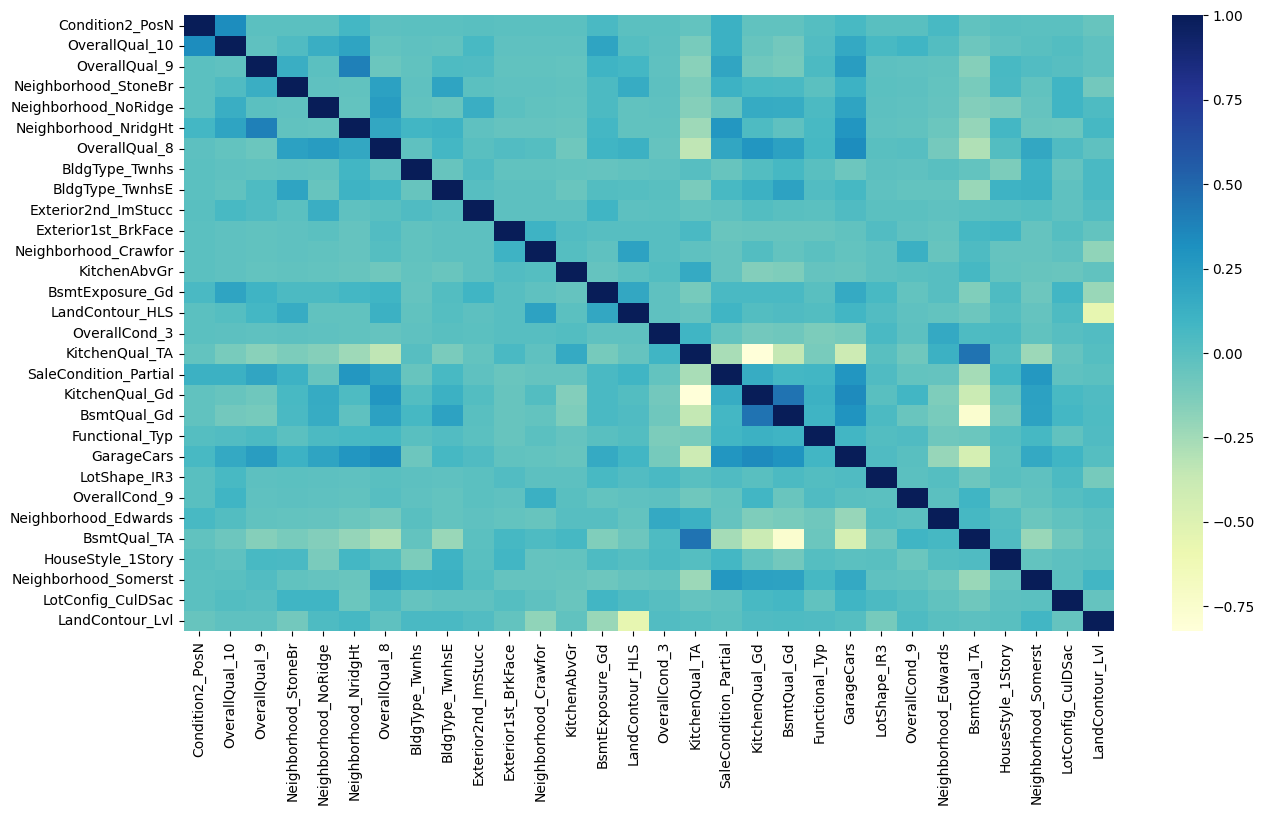

In [798]:
# Checking correlation between the predictors
plt.figure(figsize=(15,8))
# Heatmap
sns.heatmap(df_house[lasso_selected_features].corr(), cmap="YlGnBu", annot=False)
plt.show()

# **Subjective Questions**

In [799]:
params = {'alpha': [200]}

lasso_final_model, lasso_y_train, lasso_y_predicted, lasso_alpha = BuildRidgeOrLassoModel(X_train, y_train, X_test, params, model='lasso')

print('Features and Coefficients\n')
# lasso model parameters
model_parameters = list(lasso_final_model.coef_)
model_parameters.insert(0, lasso_final_model.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
lasso_selected_features = []
for k,v in sorted(list(zip(model_parameters,cols)), key=lambda x:abs(x[0]), reverse=True)[1:31]:
    lasso_selected_features.append(v)
sorted(list(zip(model_parameters,cols)), key=lambda x:abs(x[0]), reverse=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Optimum alpha for lasso is 200.000000
lasso  Regression with  200
R2 score (train) :  0.8816664452345327
R2 score (test) :  0.8765036009146666
RMSE (train) :  26567.018067821624
RMSE (test) :  30777.55133855637
Features and Coefficients



[(-371946.583, 'constant'),
 (60646.416, 'OverallQual_9'),
 (52970.595, 'OverallQual_10'),
 (28380.802, 'Neighborhood_NoRidge'),
 (27516.219, 'Neighborhood_StoneBr'),
 (25127.595, 'OverallQual_8'),
 (24133.848, 'Neighborhood_NridgHt'),
 (-20885.172, 'KitchenAbvGr'),
 (19027.099, 'Neighborhood_Crawfor'),
 (-18006.944, 'BldgType_TwnhsE'),
 (-17560.045, 'Condition2_PosN'),
 (17376.196, 'Exterior1st_BrkFace'),
 (-15712.935, 'BldgType_Twnhs'),
 (14225.73, 'BsmtExposure_Gd'),
 (12949.304, 'Functional_Typ'),
 (-12700.901, 'KitchenQual_TA'),
 (12113.701, 'GarageCars'),
 (-12084.459, 'Neighborhood_Edwards'),
 (11352.514, 'SaleCondition_Partial'),
 (10755.672, 'LandContour_HLS'),
 (-10209.208, 'KitchenQual_Gd'),
 (-10149.299, 'BsmtQual_Gd'),
 (10045.496, 'Condition1_Norm'),
 (9499.958, 'Neighborhood_Somerst'),
 (-9224.288, 'OverallCond_3'),
 (8589.832, 'LotConfig_CulDSac'),
 (8466.606, 'HouseStyle_1Story'),
 (-8413.056, 'HouseStyle_2Story'),
 (8162.55, 'BsmtCond_TA'),
 (-7897.293, 'OverallCond_4